CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [16]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_aug.npy')
y_train = np.load(DATA_PATH + 'y_train_aug.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((210, 512, 512, 1), (210, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((189, 512, 512, 1), (21, 512, 512, 1), (189, 512, 512, 1), (21, 512, 512, 1))

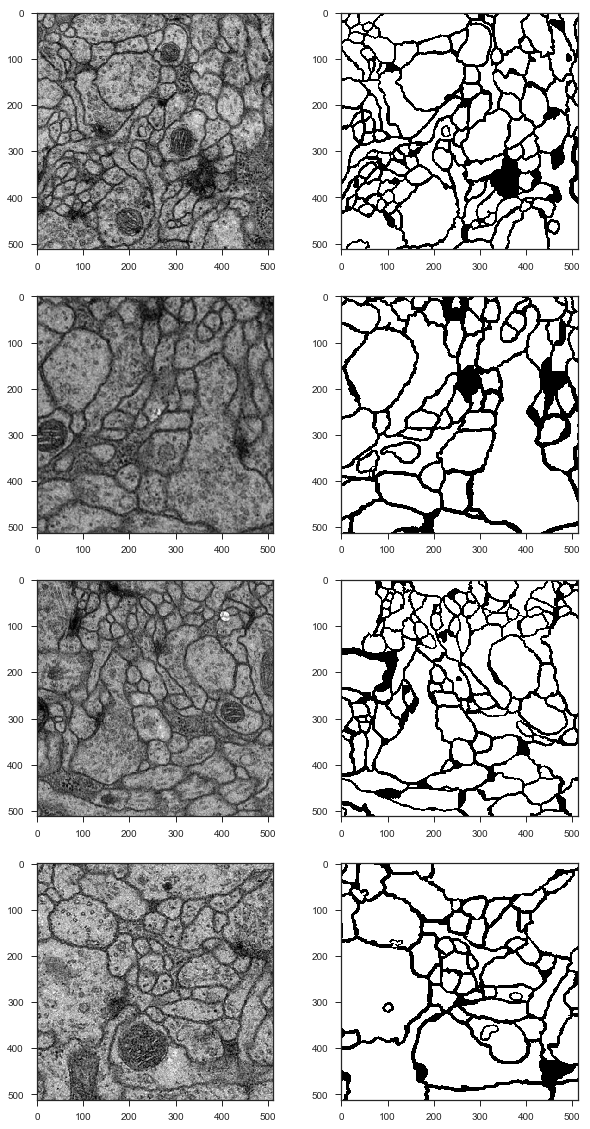

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [8]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

from Loss_Functions import cross_entropy_balanced
from ResNet_UNet_Side_Fuse import u_res_side_fuse
from Loss_Functions import dice_coef, pixel_error

In [10]:
model_unet_side_fuse = u_res_side_fuse(input_shape=(512, 512, 1))
model_unet_side_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 416         pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [11]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.5, patience=5, verbose=1, 
                             min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_RES_Fuse', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=4, epochs=200, callbacks=callback_list, verbose=2)

Train on 189 samples, validate on 21 samples


Epoch 1/200


 - 77s - loss: 1.3697 - o1_loss: 0.2386 - o2_loss: 0.2352 - o3_loss: 0.2386 - o4_loss: 0.1976 - o5_loss: 0.2324 - ofuse_loss: 0.2274 - ofuse_dice_coef: 0.3555 - ofuse_pixel_error: 0.4169 - val_loss: 1.3672 - val_o1_loss: 0.2444 - val_o2_loss: 0.2322 - val_o3_loss: 0.2267 - val_o4_loss: 0.2328 - val_o5_loss: 0.2103 - val_ofuse_loss: 0.2208 - val_ofuse_dice_coef: 0.3999 - val_ofuse_pixel_error: 0.2349



Epoch 00001: val_loss improved from inf to 1.36722, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 2/200


 - 43s - loss: 0.9500 - o1_loss: 0.1798 - o2_loss: 0.1667 - o3_loss: 0.1771 - o4_loss: 0.1320 - o5_loss: 0.1437 - ofuse_loss: 0.1506 - ofuse_dice_coef: 0.5278 - ofuse_pixel_error: 0.2241 - val_loss: 1.1660 - val_o1_loss: 0.2150 - val_o2_loss: 0.1736 - val_o3_loss: 0.1793 - val_o4_loss: 0.2483 - val_o5_loss: 0.1774 - val_ofuse_loss: 0.1725 - val_ofuse_dice_coef: 0.5601 - val_ofuse_pixel_error: 0.2027



Epoch 00002: val_loss improved from 1.36722 to 1.16604, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 3/200


 - 43s - loss: 0.6924 - o1_loss: 0.1475 - o2_loss: 0.1202 - o3_loss: 0.1160 - o4_loss: 0.1009 - o5_loss: 0.0989 - ofuse_loss: 0.1089 - ofuse_dice_coef: 0.6439 - ofuse_pixel_error: 0.1524 - val_loss: 0.8893 - val_o1_loss: 0.1640 - val_o2_loss: 0.1383 - val_o3_loss: 0.1393 - val_o4_loss: 0.1640 - val_o5_loss: 0.1573 - val_ofuse_loss: 0.1264 - val_ofuse_dice_coef: 0.6429 - val_ofuse_pixel_error: 0.1749



Epoch 00003: val_loss improved from 1.16604 to 0.88929, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 4/200


 - 43s - loss: 0.5995 - o1_loss: 0.1383 - o2_loss: 0.0996 - o3_loss: 0.0964 - o4_loss: 0.0873 - o5_loss: 0.0856 - ofuse_loss: 0.0922 - ofuse_dice_coef: 0.6948 - ofuse_pixel_error: 0.1284 - val_loss: 0.6996 - val_o1_loss: 0.1563 - val_o2_loss: 0.1080 - val_o3_loss: 0.1044 - val_o4_loss: 0.1126 - val_o5_loss: 0.1095 - val_ofuse_loss: 0.1088 - val_ofuse_dice_coef: 0.6743 - val_ofuse_pixel_error: 0.1251



Epoch 00004: val_loss improved from 0.88929 to 0.69960, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 5/200


 - 43s - loss: 0.5614 - o1_loss: 0.1341 - o2_loss: 0.0918 - o3_loss: 0.0874 - o4_loss: 0.0817 - o5_loss: 0.0806 - ofuse_loss: 0.0859 - ofuse_dice_coef: 0.7191 - ofuse_pixel_error: 0.1192 - val_loss: 0.6303 - val_o1_loss: 0.1418 - val_o2_loss: 0.1003 - val_o3_loss: 0.0974 - val_o4_loss: 0.0987 - val_o5_loss: 0.0900 - val_ofuse_loss: 0.1021 - val_ofuse_dice_coef: 0.7149 - val_ofuse_pixel_error: 0.0987



Epoch 00005: val_loss improved from 0.69960 to 0.63025, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 6/200


 - 43s - loss: 0.5358 - o1_loss: 0.1316 - o2_loss: 0.0870 - o3_loss: 0.0812 - o4_loss: 0.0775 - o5_loss: 0.0770 - ofuse_loss: 0.0814 - ofuse_dice_coef: 0.7315 - ofuse_pixel_error: 0.1133 - val_loss: 0.5974 - val_o1_loss: 0.1358 - val_o2_loss: 0.0960 - val_o3_loss: 0.0896 - val_o4_loss: 0.0903 - val_o5_loss: 0.0934 - val_ofuse_loss: 0.0925 - val_ofuse_dice_coef: 0.6776 - val_ofuse_pixel_error: 0.1218



Epoch 00006: val_loss improved from 0.63025 to 0.59744, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 7/200


 - 43s - loss: 0.5115 - o1_loss: 0.1283 - o2_loss: 0.0829 - o3_loss: 0.0762 - o4_loss: 0.0738 - o5_loss: 0.0734 - ofuse_loss: 0.0770 - ofuse_dice_coef: 0.7453 - ofuse_pixel_error: 0.1074 - val_loss: 0.5356 - val_o1_loss: 0.1307 - val_o2_loss: 0.0864 - val_o3_loss: 0.0793 - val_o4_loss: 0.0787 - val_o5_loss: 0.0796 - val_ofuse_loss: 0.0809 - val_ofuse_dice_coef: 0.7258 - val_ofuse_pixel_error: 0.1113



Epoch 00007: val_loss improved from 0.59744 to 0.53558, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 8/200


 - 43s - loss: 0.5131 - o1_loss: 0.1290 - o2_loss: 0.0834 - o3_loss: 0.0759 - o4_loss: 0.0740 - o5_loss: 0.0737 - ofuse_loss: 0.0771 - ofuse_dice_coef: 0.7450 - ofuse_pixel_error: 0.1084 - val_loss: 0.5147 - val_o1_loss: 0.1260 - val_o2_loss: 0.0835 - val_o3_loss: 0.0763 - val_o4_loss: 0.0746 - val_o5_loss: 0.0758 - val_ofuse_loss: 0.0786 - val_ofuse_dice_coef: 0.7267 - val_ofuse_pixel_error: 0.1057



Epoch 00008: val_loss improved from 0.53558 to 0.51475, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 9/200


 - 43s - loss: 0.4880 - o1_loss: 0.1249 - o2_loss: 0.0792 - o3_loss: 0.0713 - o4_loss: 0.0699 - o5_loss: 0.0699 - ofuse_loss: 0.0728 - ofuse_dice_coef: 0.7579 - ofuse_pixel_error: 0.1025 - val_loss: 0.5654 - val_o1_loss: 0.1324 - val_o2_loss: 0.0935 - val_o3_loss: 0.0845 - val_o4_loss: 0.0838 - val_o5_loss: 0.0858 - val_ofuse_loss: 0.0855 - val_ofuse_dice_coef: 0.7057 - val_ofuse_pixel_error: 0.1337



Epoch 00009: val_loss did not improve
Epoch 10/200


 - 44s - loss: 0.4862 - o1_loss: 0.1249 - o2_loss: 0.0789 - o3_loss: 0.0709 - o4_loss: 0.0697 - o5_loss: 0.0697 - ofuse_loss: 0.0721 - ofuse_dice_coef: 0.7589 - ofuse_pixel_error: 0.1022 - val_loss: 0.5111 - val_o1_loss: 0.1237 - val_o2_loss: 0.0817 - val_o3_loss: 0.0749 - val_o4_loss: 0.0770 - val_o5_loss: 0.0787 - val_ofuse_loss: 0.0752 - val_ofuse_dice_coef: 0.7415 - val_ofuse_pixel_error: 0.1093



Epoch 00010: val_loss improved from 0.51475 to 0.51109, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 11/200


 - 44s - loss: 0.4614 - o1_loss: 0.1215 - o2_loss: 0.0747 - o3_loss: 0.0665 - o4_loss: 0.0657 - o5_loss: 0.0656 - ofuse_loss: 0.0675 - ofuse_dice_coef: 0.7733 - ofuse_pixel_error: 0.0957 - val_loss: 0.5095 - val_o1_loss: 0.1252 - val_o2_loss: 0.0820 - val_o3_loss: 0.0745 - val_o4_loss: 0.0752 - val_o5_loss: 0.0774 - val_ofuse_loss: 0.0751 - val_ofuse_dice_coef: 0.7366 - val_ofuse_pixel_error: 0.1069



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000500000023749.

Epoch 00011: val_loss improved from 0.51109 to 0.50948, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 12/200


 - 45s - loss: 0.4436 - o1_loss: 0.1191 - o2_loss: 0.0717 - o3_loss: 0.0633 - o4_loss: 0.0625 - o5_loss: 0.0625 - ofuse_loss: 0.0644 - ofuse_dice_coef: 0.7818 - ofuse_pixel_error: 0.0911 - val_loss: 0.4842 - val_o1_loss: 0.1216 - val_o2_loss: 0.0786 - val_o3_loss: 0.0713 - val_o4_loss: 0.0705 - val_o5_loss: 0.0699 - val_ofuse_loss: 0.0723 - val_ofuse_dice_coef: 0.7575 - val_ofuse_pixel_error: 0.0930



Epoch 00012: val_loss improved from 0.50948 to 0.48424, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 13/200


 - 45s - loss: 0.4353 - o1_loss: 0.1182 - o2_loss: 0.0702 - o3_loss: 0.0619 - o4_loss: 0.0612 - o5_loss: 0.0610 - ofuse_loss: 0.0628 - ofuse_dice_coef: 0.7872 - ofuse_pixel_error: 0.0891 - val_loss: 0.4916 - val_o1_loss: 0.1235 - val_o2_loss: 0.0796 - val_o3_loss: 0.0717 - val_o4_loss: 0.0714 - val_o5_loss: 0.0722 - val_ofuse_loss: 0.0732 - val_ofuse_dice_coef: 0.7623 - val_ofuse_pixel_error: 0.1004



Epoch 00013: val_loss did not improve
Epoch 14/200


 - 44s - loss: 0.4279 - o1_loss: 0.1171 - o2_loss: 0.0689 - o3_loss: 0.0606 - o4_loss: 0.0599 - o5_loss: 0.0599 - ofuse_loss: 0.0615 - ofuse_dice_coef: 0.7917 - ofuse_pixel_error: 0.0871 - val_loss: 0.4889 - val_o1_loss: 0.1221 - val_o2_loss: 0.0795 - val_o3_loss: 0.0716 - val_o4_loss: 0.0711 - val_o5_loss: 0.0718 - val_ofuse_loss: 0.0728 - val_ofuse_dice_coef: 0.7544 - val_ofuse_pixel_error: 0.1072



Epoch 00014: val_loss did not improve
Epoch 15/200


 - 44s - loss: 0.4208 - o1_loss: 0.1163 - o2_loss: 0.0678 - o3_loss: 0.0593 - o4_loss: 0.0585 - o5_loss: 0.0587 - ofuse_loss: 0.0602 - ofuse_dice_coef: 0.7950 - ofuse_pixel_error: 0.0861 - val_loss: 0.4992 - val_o1_loss: 0.1227 - val_o2_loss: 0.0807 - val_o3_loss: 0.0749 - val_o4_loss: 0.0731 - val_o5_loss: 0.0725 - val_ofuse_loss: 0.0753 - val_ofuse_dice_coef: 0.7693 - val_ofuse_pixel_error: 0.0869



Epoch 00015: val_loss did not improve
Epoch 16/200


 - 44s - loss: 0.4208 - o1_loss: 0.1162 - o2_loss: 0.0678 - o3_loss: 0.0593 - o4_loss: 0.0587 - o5_loss: 0.0587 - ofuse_loss: 0.0601 - ofuse_dice_coef: 0.7956 - ofuse_pixel_error: 0.0853 - val_loss: 0.5145 - val_o1_loss: 0.1262 - val_o2_loss: 0.0825 - val_o3_loss: 0.0765 - val_o4_loss: 0.0765 - val_o5_loss: 0.0759 - val_ofuse_loss: 0.0769 - val_ofuse_dice_coef: 0.7631 - val_ofuse_pixel_error: 0.0997



Epoch 00016: val_loss did not improve
Epoch 17/200


 - 44s - loss: 0.4112 - o1_loss: 0.1154 - o2_loss: 0.0661 - o3_loss: 0.0576 - o4_loss: 0.0570 - o5_loss: 0.0570 - ofuse_loss: 0.0583 - ofuse_dice_coef: 0.8014 - ofuse_pixel_error: 0.0828 - val_loss: 0.5162 - val_o1_loss: 0.1258 - val_o2_loss: 0.0827 - val_o3_loss: 0.0771 - val_o4_loss: 0.0765 - val_o5_loss: 0.0759 - val_ofuse_loss: 0.0782 - val_ofuse_dice_coef: 0.7749 - val_ofuse_pixel_error: 0.0873



Epoch 00017: val_loss did not improve
Epoch 18/200


 - 44s - loss: 0.4069 - o1_loss: 0.1147 - o2_loss: 0.0654 - o3_loss: 0.0568 - o4_loss: 0.0563 - o5_loss: 0.0562 - ofuse_loss: 0.0575 - ofuse_dice_coef: 0.8037 - ofuse_pixel_error: 0.0815 - val_loss: 0.5748 - val_o1_loss: 0.1295 - val_o2_loss: 0.0926 - val_o3_loss: 0.0888 - val_o4_loss: 0.0878 - val_o5_loss: 0.0868 - val_ofuse_loss: 0.0893 - val_ofuse_dice_coef: 0.7730 - val_ofuse_pixel_error: 0.0822



Epoch 00018: val_loss did not improve
Epoch 19/200


 - 44s - loss: 0.4002 - o1_loss: 0.1143 - o2_loss: 0.0643 - o3_loss: 0.0555 - o4_loss: 0.0550 - o5_loss: 0.0550 - ofuse_loss: 0.0561 - ofuse_dice_coef: 0.8078 - ofuse_pixel_error: 0.0795 - val_loss: 0.4972 - val_o1_loss: 0.1229 - val_o2_loss: 0.0796 - val_o3_loss: 0.0734 - val_o4_loss: 0.0734 - val_o5_loss: 0.0734 - val_ofuse_loss: 0.0744 - val_ofuse_dice_coef: 0.7747 - val_ofuse_pixel_error: 0.0958



Epoch 00019: val_loss did not improve
Epoch 20/200


 - 44s - loss: 0.3969 - o1_loss: 0.1139 - o2_loss: 0.0637 - o3_loss: 0.0549 - o4_loss: 0.0543 - o5_loss: 0.0544 - ofuse_loss: 0.0555 - ofuse_dice_coef: 0.8093 - ofuse_pixel_error: 0.0791 - val_loss: 0.5384 - val_o1_loss: 0.1253 - val_o2_loss: 0.0853 - val_o3_loss: 0.0820 - val_o4_loss: 0.0826 - val_o5_loss: 0.0811 - val_ofuse_loss: 0.0822 - val_ofuse_dice_coef: 0.7770 - val_ofuse_pixel_error: 0.0855



Epoch 00020: val_loss did not improve
Epoch 21/200


 - 44s - loss: 0.3908 - o1_loss: 0.1133 - o2_loss: 0.0627 - o3_loss: 0.0538 - o4_loss: 0.0533 - o5_loss: 0.0533 - ofuse_loss: 0.0543 - ofuse_dice_coef: 0.8136 - ofuse_pixel_error: 0.0765 - val_loss: 0.5132 - val_o1_loss: 0.1234 - val_o2_loss: 0.0815 - val_o3_loss: 0.0766 - val_o4_loss: 0.0774 - val_o5_loss: 0.0768 - val_ofuse_loss: 0.0776 - val_ofuse_dice_coef: 0.7799 - val_ofuse_pixel_error: 0.0926



Epoch 00021: val_loss did not improve
Epoch 22/200


 - 44s - loss: 0.3872 - o1_loss: 0.1130 - o2_loss: 0.0621 - o3_loss: 0.0531 - o4_loss: 0.0527 - o5_loss: 0.0527 - ofuse_loss: 0.0536 - ofuse_dice_coef: 0.8158 - ofuse_pixel_error: 0.0759 - val_loss: 0.5232 - val_o1_loss: 0.1240 - val_o2_loss: 0.0832 - val_o3_loss: 0.0787 - val_o4_loss: 0.0794 - val_o5_loss: 0.0783 - val_ofuse_loss: 0.0795 - val_ofuse_dice_coef: 0.7873 - val_ofuse_pixel_error: 0.0864



Epoch 00022: val_loss did not improve
Epoch 23/200


 - 44s - loss: 0.3947 - o1_loss: 0.1141 - o2_loss: 0.0635 - o3_loss: 0.0544 - o4_loss: 0.0539 - o5_loss: 0.0539 - ofuse_loss: 0.0548 - ofuse_dice_coef: 0.8121 - ofuse_pixel_error: 0.0769 - val_loss: 0.5390 - val_o1_loss: 0.1242 - val_o2_loss: 0.0852 - val_o3_loss: 0.0821 - val_o4_loss: 0.0832 - val_o5_loss: 0.0817 - val_ofuse_loss: 0.0825 - val_ofuse_dice_coef: 0.7842 - val_ofuse_pixel_error: 0.0869



Epoch 00023: val_loss did not improve
Epoch 24/200


 - 44s - loss: 0.3820 - o1_loss: 0.1127 - o2_loss: 0.0613 - o3_loss: 0.0521 - o4_loss: 0.0517 - o5_loss: 0.0517 - ofuse_loss: 0.0525 - ofuse_dice_coef: 0.8189 - ofuse_pixel_error: 0.0744 - val_loss: 0.5272 - val_o1_loss: 0.1228 - val_o2_loss: 0.0836 - val_o3_loss: 0.0800 - val_o4_loss: 0.0807 - val_o5_loss: 0.0795 - val_ofuse_loss: 0.0805 - val_ofuse_dice_coef: 0.7848 - val_ofuse_pixel_error: 0.0876



Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.000250000011874.

Epoch 00024: val_loss did not improve
Epoch 25/200


 - 44s - loss: 0.3733 - o1_loss: 0.1119 - o2_loss: 0.0598 - o3_loss: 0.0505 - o4_loss: 0.0501 - o5_loss: 0.0501 - ofuse_loss: 0.0508 - ofuse_dice_coef: 0.8236 - ofuse_pixel_error: 0.0716 - val_loss: 0.5236 - val_o1_loss: 0.1230 - val_o2_loss: 0.0827 - val_o3_loss: 0.0792 - val_o4_loss: 0.0803 - val_o5_loss: 0.0788 - val_ofuse_loss: 0.0797 - val_ofuse_dice_coef: 0.7873 - val_ofuse_pixel_error: 0.0867



Epoch 00025: val_loss did not improve
Epoch 26/200


 - 44s - loss: 0.3655 - o1_loss: 0.1112 - o2_loss: 0.0587 - o3_loss: 0.0490 - o4_loss: 0.0486 - o5_loss: 0.0487 - ofuse_loss: 0.0494 - ofuse_dice_coef: 0.8288 - ofuse_pixel_error: 0.0693 - val_loss: 0.5431 - val_o1_loss: 0.1246 - val_o2_loss: 0.0858 - val_o3_loss: 0.0830 - val_o4_loss: 0.0838 - val_o5_loss: 0.0821 - val_ofuse_loss: 0.0838 - val_ofuse_dice_coef: 0.7931 - val_ofuse_pixel_error: 0.0817



Epoch 00026: val_loss did not improve
Epoch 27/200


 - 44s - loss: 0.3634 - o1_loss: 0.1110 - o2_loss: 0.0582 - o3_loss: 0.0487 - o4_loss: 0.0483 - o5_loss: 0.0483 - ofuse_loss: 0.0489 - ofuse_dice_coef: 0.8305 - ofuse_pixel_error: 0.0685 - val_loss: 0.5555 - val_o1_loss: 0.1238 - val_o2_loss: 0.0868 - val_o3_loss: 0.0858 - val_o4_loss: 0.0875 - val_o5_loss: 0.0858 - val_ofuse_loss: 0.0859 - val_ofuse_dice_coef: 0.7919 - val_ofuse_pixel_error: 0.0821



Epoch 00027: val_loss did not improve
Epoch 28/200


 - 44s - loss: 0.3611 - o1_loss: 0.1109 - o2_loss: 0.0579 - o3_loss: 0.0482 - o4_loss: 0.0478 - o5_loss: 0.0478 - ofuse_loss: 0.0485 - ofuse_dice_coef: 0.8317 - ofuse_pixel_error: 0.0684 - val_loss: 0.5389 - val_o1_loss: 0.1238 - val_o2_loss: 0.0844 - val_o3_loss: 0.0821 - val_o4_loss: 0.0837 - val_o5_loss: 0.0822 - val_ofuse_loss: 0.0826 - val_ofuse_dice_coef: 0.7897 - val_ofuse_pixel_error: 0.0884



Epoch 00028: val_loss did not improve
Epoch 29/200


 - 43s - loss: 0.3586 - o1_loss: 0.1108 - o2_loss: 0.0576 - o3_loss: 0.0477 - o4_loss: 0.0473 - o5_loss: 0.0473 - ofuse_loss: 0.0480 - ofuse_dice_coef: 0.8330 - ofuse_pixel_error: 0.0674 - val_loss: 0.5713 - val_o1_loss: 0.1261 - val_o2_loss: 0.0888 - val_o3_loss: 0.0880 - val_o4_loss: 0.0909 - val_o5_loss: 0.0887 - val_ofuse_loss: 0.0887 - val_ofuse_dice_coef: 0.7917 - val_ofuse_pixel_error: 0.0856



Epoch 00029: val_loss did not improve
Epoch 30/200


 - 43s - loss: 0.3528 - o1_loss: 0.1103 - o2_loss: 0.0567 - o3_loss: 0.0466 - o4_loss: 0.0462 - o5_loss: 0.0462 - ofuse_loss: 0.0469 - ofuse_dice_coef: 0.8374 - ofuse_pixel_error: 0.0656 - val_loss: 0.5676 - val_o1_loss: 0.1260 - val_o2_loss: 0.0879 - val_o3_loss: 0.0874 - val_o4_loss: 0.0902 - val_o5_loss: 0.0881 - val_ofuse_loss: 0.0879 - val_ofuse_dice_coef: 0.7928 - val_ofuse_pixel_error: 0.0847



Epoch 00030: val_loss did not improve
Epoch 31/200


 - 43s - loss: 0.3541 - o1_loss: 0.1106 - o2_loss: 0.0568 - o3_loss: 0.0468 - o4_loss: 0.0464 - o5_loss: 0.0464 - ofuse_loss: 0.0470 - ofuse_dice_coef: 0.8368 - ofuse_pixel_error: 0.0658 - val_loss: 0.5706 - val_o1_loss: 0.1255 - val_o2_loss: 0.0886 - val_o3_loss: 0.0879 - val_o4_loss: 0.0910 - val_o5_loss: 0.0889 - val_ofuse_loss: 0.0887 - val_ofuse_dice_coef: 0.7914 - val_ofuse_pixel_error: 0.0871



Epoch 00031: val_loss did not improve
Epoch 32/200


 - 43s - loss: 0.3502 - o1_loss: 0.1102 - o2_loss: 0.0563 - o3_loss: 0.0461 - o4_loss: 0.0456 - o5_loss: 0.0456 - ofuse_loss: 0.0464 - ofuse_dice_coef: 0.8385 - ofuse_pixel_error: 0.0652 - val_loss: 0.5928 - val_o1_loss: 0.1280 - val_o2_loss: 0.0917 - val_o3_loss: 0.0915 - val_o4_loss: 0.0955 - val_o5_loss: 0.0932 - val_ofuse_loss: 0.0929 - val_ofuse_dice_coef: 0.7934 - val_ofuse_pixel_error: 0.0848



Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.000125000005937.

Epoch 00032: val_loss did not improve
Epoch 33/200


 - 43s - loss: 0.3430 - o1_loss: 0.1097 - o2_loss: 0.0552 - o3_loss: 0.0447 - o4_loss: 0.0443 - o5_loss: 0.0443 - ofuse_loss: 0.0449 - ofuse_dice_coef: 0.8431 - ofuse_pixel_error: 0.0626 - val_loss: 0.5803 - val_o1_loss: 0.1258 - val_o2_loss: 0.0893 - val_o3_loss: 0.0897 - val_o4_loss: 0.0939 - val_o5_loss: 0.0909 - val_ofuse_loss: 0.0908 - val_ofuse_dice_coef: 0.7937 - val_ofuse_pixel_error: 0.0858



Epoch 00033: val_loss did not improve
Epoch 34/200


 - 43s - loss: 0.3402 - o1_loss: 0.1095 - o2_loss: 0.0548 - o3_loss: 0.0441 - o4_loss: 0.0437 - o5_loss: 0.0437 - ofuse_loss: 0.0444 - ofuse_dice_coef: 0.8451 - ofuse_pixel_error: 0.0617 - val_loss: 0.5993 - val_o1_loss: 0.1266 - val_o2_loss: 0.0916 - val_o3_loss: 0.0936 - val_o4_loss: 0.0980 - val_o5_loss: 0.0948 - val_ofuse_loss: 0.0947 - val_ofuse_dice_coef: 0.7955 - val_ofuse_pixel_error: 0.0852



Epoch 00034: val_loss did not improve
Epoch 35/200


 - 43s - loss: 0.3388 - o1_loss: 0.1094 - o2_loss: 0.0545 - o3_loss: 0.0438 - o4_loss: 0.0435 - o5_loss: 0.0435 - ofuse_loss: 0.0441 - ofuse_dice_coef: 0.8458 - ofuse_pixel_error: 0.0617 - val_loss: 0.5989 - val_o1_loss: 0.1274 - val_o2_loss: 0.0914 - val_o3_loss: 0.0935 - val_o4_loss: 0.0978 - val_o5_loss: 0.0946 - val_ofuse_loss: 0.0943 - val_ofuse_dice_coef: 0.7957 - val_ofuse_pixel_error: 0.0850



Epoch 00035: val_loss did not improve
Epoch 36/200


 - 43s - loss: 0.3365 - o1_loss: 0.1094 - o2_loss: 0.0542 - o3_loss: 0.0434 - o4_loss: 0.0430 - o5_loss: 0.0430 - ofuse_loss: 0.0436 - ofuse_dice_coef: 0.8479 - ofuse_pixel_error: 0.0605 - val_loss: 0.5900 - val_o1_loss: 0.1262 - val_o2_loss: 0.0899 - val_o3_loss: 0.0918 - val_o4_loss: 0.0964 - val_o5_loss: 0.0930 - val_ofuse_loss: 0.0927 - val_ofuse_dice_coef: 0.7971 - val_ofuse_pixel_error: 0.0845



Epoch 00036: val_loss did not improve
Epoch 37/200


 - 43s - loss: 0.3359 - o1_loss: 0.1093 - o2_loss: 0.0541 - o3_loss: 0.0432 - o4_loss: 0.0429 - o5_loss: 0.0429 - ofuse_loss: 0.0434 - ofuse_dice_coef: 0.8487 - ofuse_pixel_error: 0.0605 - val_loss: 0.6178 - val_o1_loss: 0.1284 - val_o2_loss: 0.0937 - val_o3_loss: 0.0969 - val_o4_loss: 0.1022 - val_o5_loss: 0.0985 - val_ofuse_loss: 0.0981 - val_ofuse_dice_coef: 0.7972 - val_ofuse_pixel_error: 0.0830



Epoch 00037: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.

Epoch 00037: val_loss did not improve
Epoch 38/200


 - 43s - loss: 0.3356 - o1_loss: 0.1095 - o2_loss: 0.0541 - o3_loss: 0.0431 - o4_loss: 0.0428 - o5_loss: 0.0428 - ofuse_loss: 0.0433 - ofuse_dice_coef: 0.8482 - ofuse_pixel_error: 0.0607 - val_loss: 0.6159 - val_o1_loss: 0.1282 - val_o2_loss: 0.0935 - val_o3_loss: 0.0963 - val_o4_loss: 0.1018 - val_o5_loss: 0.0982 - val_ofuse_loss: 0.0978 - val_ofuse_dice_coef: 0.7970 - val_ofuse_pixel_error: 0.0838



Epoch 00038: val_loss did not improve
Epoch 39/200


 - 43s - loss: 0.3315 - o1_loss: 0.1091 - o2_loss: 0.0535 - o3_loss: 0.0423 - o4_loss: 0.0420 - o5_loss: 0.0420 - ofuse_loss: 0.0426 - ofuse_dice_coef: 0.8512 - ofuse_pixel_error: 0.0587 - val_loss: 0.6166 - val_o1_loss: 0.1280 - val_o2_loss: 0.0934 - val_o3_loss: 0.0967 - val_o4_loss: 0.1021 - val_o5_loss: 0.0984 - val_ofuse_loss: 0.0980 - val_ofuse_dice_coef: 0.7966 - val_ofuse_pixel_error: 0.0851



Epoch 00039: val_loss did not improve
Epoch 40/200


 - 43s - loss: 0.3302 - o1_loss: 0.1091 - o2_loss: 0.0533 - o3_loss: 0.0421 - o4_loss: 0.0417 - o5_loss: 0.0417 - ofuse_loss: 0.0423 - ofuse_dice_coef: 0.8520 - ofuse_pixel_error: 0.0588 - val_loss: 0.6200 - val_o1_loss: 0.1281 - val_o2_loss: 0.0939 - val_o3_loss: 0.0973 - val_o4_loss: 0.1028 - val_o5_loss: 0.0991 - val_ofuse_loss: 0.0988 - val_ofuse_dice_coef: 0.7977 - val_ofuse_pixel_error: 0.0848



Epoch 00040: val_loss did not improve
Epoch 41/200


 - 43s - loss: 0.3305 - o1_loss: 0.1091 - o2_loss: 0.0533 - o3_loss: 0.0421 - o4_loss: 0.0418 - o5_loss: 0.0418 - ofuse_loss: 0.0424 - ofuse_dice_coef: 0.8523 - ofuse_pixel_error: 0.0588 - val_loss: 0.6182 - val_o1_loss: 0.1283 - val_o2_loss: 0.0937 - val_o3_loss: 0.0968 - val_o4_loss: 0.1022 - val_o5_loss: 0.0987 - val_ofuse_loss: 0.0984 - val_ofuse_dice_coef: 0.7976 - val_ofuse_pixel_error: 0.0860



Epoch 00041: val_loss did not improve
Epoch 42/200


 - 43s - loss: 0.3313 - o1_loss: 0.1092 - o2_loss: 0.0535 - o3_loss: 0.0422 - o4_loss: 0.0419 - o5_loss: 0.0419 - ofuse_loss: 0.0425 - ofuse_dice_coef: 0.8514 - ofuse_pixel_error: 0.0593 - val_loss: 0.6371 - val_o1_loss: 0.1292 - val_o2_loss: 0.0959 - val_o3_loss: 0.1006 - val_o4_loss: 0.1067 - val_o5_loss: 0.1027 - val_ofuse_loss: 0.1020 - val_ofuse_dice_coef: 0.7988 - val_ofuse_pixel_error: 0.0828



Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.

Epoch 00042: val_loss did not improve
Epoch 43/200


 - 43s - loss: 0.3276 - o1_loss: 0.1089 - o2_loss: 0.0529 - o3_loss: 0.0416 - o4_loss: 0.0412 - o5_loss: 0.0412 - ofuse_loss: 0.0418 - ofuse_dice_coef: 0.8535 - ofuse_pixel_error: 0.0579 - val_loss: 0.6325 - val_o1_loss: 0.1288 - val_o2_loss: 0.0953 - val_o3_loss: 0.0997 - val_o4_loss: 0.1058 - val_o5_loss: 0.1017 - val_ofuse_loss: 0.1012 - val_ofuse_dice_coef: 0.7979 - val_ofuse_pixel_error: 0.0840



Epoch 00043: val_loss did not improve
Epoch 44/200


 - 43s - loss: 0.3272 - o1_loss: 0.1089 - o2_loss: 0.0528 - o3_loss: 0.0415 - o4_loss: 0.0411 - o5_loss: 0.0411 - ofuse_loss: 0.0417 - ofuse_dice_coef: 0.8538 - ofuse_pixel_error: 0.0579 - val_loss: 0.6257 - val_o1_loss: 0.1286 - val_o2_loss: 0.0944 - val_o3_loss: 0.0982 - val_o4_loss: 0.1044 - val_o5_loss: 0.1004 - val_ofuse_loss: 0.0999 - val_ofuse_dice_coef: 0.7978 - val_ofuse_pixel_error: 0.0846



Epoch 00044: val_loss did not improve
Epoch 45/200


 - 45s - loss: 0.3262 - o1_loss: 0.1089 - o2_loss: 0.0527 - o3_loss: 0.0413 - o4_loss: 0.0409 - o5_loss: 0.0409 - ofuse_loss: 0.0415 - ofuse_dice_coef: 0.8546 - ofuse_pixel_error: 0.0576 - val_loss: 0.6314 - val_o1_loss: 0.1290 - val_o2_loss: 0.0952 - val_o3_loss: 0.0993 - val_o4_loss: 0.1056 - val_o5_loss: 0.1014 - val_ofuse_loss: 0.1010 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0838



Epoch 00045: val_loss did not improve
Epoch 46/200


 - 44s - loss: 0.3272 - o1_loss: 0.1089 - o2_loss: 0.0529 - o3_loss: 0.0415 - o4_loss: 0.0411 - o5_loss: 0.0411 - ofuse_loss: 0.0417 - ofuse_dice_coef: 0.8541 - ofuse_pixel_error: 0.0580 - val_loss: 0.6293 - val_o1_loss: 0.1280 - val_o2_loss: 0.0946 - val_o3_loss: 0.0991 - val_o4_loss: 0.1056 - val_o5_loss: 0.1012 - val_ofuse_loss: 0.1007 - val_ofuse_dice_coef: 0.7982 - val_ofuse_pixel_error: 0.0839



Epoch 00046: val_loss did not improve
Epoch 47/200


 - 44s - loss: 0.3273 - o1_loss: 0.1090 - o2_loss: 0.0529 - o3_loss: 0.0415 - o4_loss: 0.0412 - o5_loss: 0.0411 - ofuse_loss: 0.0417 - ofuse_dice_coef: 0.8538 - ofuse_pixel_error: 0.0582 - val_loss: 0.6312 - val_o1_loss: 0.1285 - val_o2_loss: 0.0951 - val_o3_loss: 0.0993 - val_o4_loss: 0.1057 - val_o5_loss: 0.1016 - val_ofuse_loss: 0.1011 - val_ofuse_dice_coef: 0.7984 - val_ofuse_pixel_error: 0.0838



Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.

Epoch 00047: val_loss did not improve
Epoch 48/200


 - 43s - loss: 0.3261 - o1_loss: 0.1089 - o2_loss: 0.0527 - o3_loss: 0.0412 - o4_loss: 0.0409 - o5_loss: 0.0409 - ofuse_loss: 0.0414 - ofuse_dice_coef: 0.8545 - ofuse_pixel_error: 0.0576 - val_loss: 0.6328 - val_o1_loss: 0.1288 - val_o2_loss: 0.0953 - val_o3_loss: 0.0995 - val_o4_loss: 0.1060 - val_o5_loss: 0.1019 - val_ofuse_loss: 0.1014 - val_ofuse_dice_coef: 0.7981 - val_ofuse_pixel_error: 0.0845



Epoch 00048: val_loss did not improve
Epoch 49/200


 - 43s - loss: 0.3252 - o1_loss: 0.1088 - o2_loss: 0.0526 - o3_loss: 0.0411 - o4_loss: 0.0407 - o5_loss: 0.0407 - ofuse_loss: 0.0413 - ofuse_dice_coef: 0.8551 - ofuse_pixel_error: 0.0573 - val_loss: 0.6319 - val_o1_loss: 0.1286 - val_o2_loss: 0.0952 - val_o3_loss: 0.0994 - val_o4_loss: 0.1058 - val_o5_loss: 0.1016 - val_ofuse_loss: 0.1012 - val_ofuse_dice_coef: 0.7981 - val_ofuse_pixel_error: 0.0845



Epoch 00049: val_loss did not improve
Epoch 50/200


 - 43s - loss: 0.3236 - o1_loss: 0.1087 - o2_loss: 0.0524 - o3_loss: 0.0408 - o4_loss: 0.0404 - o5_loss: 0.0404 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8561 - ofuse_pixel_error: 0.0569 - val_loss: 0.6288 - val_o1_loss: 0.1283 - val_o2_loss: 0.0948 - val_o3_loss: 0.0988 - val_o4_loss: 0.1052 - val_o5_loss: 0.1010 - val_ofuse_loss: 0.1007 - val_ofuse_dice_coef: 0.7981 - val_ofuse_pixel_error: 0.0849



Epoch 00050: val_loss did not improve
Epoch 51/200


 - 43s - loss: 0.3251 - o1_loss: 0.1089 - o2_loss: 0.0526 - o3_loss: 0.0410 - o4_loss: 0.0407 - o5_loss: 0.0407 - ofuse_loss: 0.0412 - ofuse_dice_coef: 0.8557 - ofuse_pixel_error: 0.0570 - val_loss: 0.6364 - val_o1_loss: 0.1286 - val_o2_loss: 0.0956 - val_o3_loss: 0.1004 - val_o4_loss: 0.1070 - val_o5_loss: 0.1027 - val_ofuse_loss: 0.1022 - val_ofuse_dice_coef: 0.7984 - val_ofuse_pixel_error: 0.0841



Epoch 00051: val_loss did not improve
Epoch 52/200


 - 43s - loss: 0.3250 - o1_loss: 0.1088 - o2_loss: 0.0525 - o3_loss: 0.0410 - o4_loss: 0.0407 - o5_loss: 0.0406 - ofuse_loss: 0.0412 - ofuse_dice_coef: 0.8553 - ofuse_pixel_error: 0.0577 - val_loss: 0.6322 - val_o1_loss: 0.1287 - val_o2_loss: 0.0951 - val_o3_loss: 0.0994 - val_o4_loss: 0.1059 - val_o5_loss: 0.1017 - val_ofuse_loss: 0.1013 - val_ofuse_dice_coef: 0.7982 - val_ofuse_pixel_error: 0.0848



Epoch 00052: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00052: val_loss did not improve
Epoch 53/200


 - 43s - loss: 0.3237 - o1_loss: 0.1088 - o2_loss: 0.0524 - o3_loss: 0.0407 - o4_loss: 0.0404 - o5_loss: 0.0404 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8564 - ofuse_pixel_error: 0.0567 - val_loss: 0.6332 - val_o1_loss: 0.1287 - val_o2_loss: 0.0953 - val_o3_loss: 0.0996 - val_o4_loss: 0.1061 - val_o5_loss: 0.1019 - val_ofuse_loss: 0.1016 - val_ofuse_dice_coef: 0.7984 - val_ofuse_pixel_error: 0.0847



Epoch 00053: val_loss did not improve
Epoch 54/200


 - 43s - loss: 0.3239 - o1_loss: 0.1088 - o2_loss: 0.0524 - o3_loss: 0.0408 - o4_loss: 0.0405 - o5_loss: 0.0405 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8564 - ofuse_pixel_error: 0.0567 - val_loss: 0.6328 - val_o1_loss: 0.1284 - val_o2_loss: 0.0952 - val_o3_loss: 0.0997 - val_o4_loss: 0.1061 - val_o5_loss: 0.1018 - val_ofuse_loss: 0.1015 - val_ofuse_dice_coef: 0.7983 - val_ofuse_pixel_error: 0.0847



Epoch 00054: val_loss did not improve
Epoch 55/200


 - 43s - loss: 0.3240 - o1_loss: 0.1088 - o2_loss: 0.0524 - o3_loss: 0.0408 - o4_loss: 0.0405 - o5_loss: 0.0405 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8558 - ofuse_pixel_error: 0.0572 - val_loss: 0.6353 - val_o1_loss: 0.1287 - val_o2_loss: 0.0955 - val_o3_loss: 0.1000 - val_o4_loss: 0.1067 - val_o5_loss: 0.1024 - val_ofuse_loss: 0.1020 - val_ofuse_dice_coef: 0.7983 - val_ofuse_pixel_error: 0.0847



Epoch 00055: val_loss did not improve
Epoch 56/200


 - 43s - loss: 0.3241 - o1_loss: 0.1088 - o2_loss: 0.0524 - o3_loss: 0.0408 - o4_loss: 0.0405 - o5_loss: 0.0405 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8564 - ofuse_pixel_error: 0.0566 - val_loss: 0.6370 - val_o1_loss: 0.1288 - val_o2_loss: 0.0958 - val_o3_loss: 0.1004 - val_o4_loss: 0.1070 - val_o5_loss: 0.1028 - val_ofuse_loss: 0.1023 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0846



Epoch 00056: val_loss did not improve
Epoch 57/200


 - 43s - loss: 0.3238 - o1_loss: 0.1087 - o2_loss: 0.0524 - o3_loss: 0.0408 - o4_loss: 0.0405 - o5_loss: 0.0405 - ofuse_loss: 0.0410 - ofuse_dice_coef: 0.8559 - ofuse_pixel_error: 0.0574 - val_loss: 0.6388 - val_o1_loss: 0.1290 - val_o2_loss: 0.0959 - val_o3_loss: 0.1007 - val_o4_loss: 0.1074 - val_o5_loss: 0.1031 - val_ofuse_loss: 0.1027 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0843



Epoch 00057: val_loss did not improve
Epoch 58/200


 - 43s - loss: 0.3257 - o1_loss: 0.1089 - o2_loss: 0.0526 - o3_loss: 0.0411 - o4_loss: 0.0409 - o5_loss: 0.0409 - ofuse_loss: 0.0413 - ofuse_dice_coef: 0.8563 - ofuse_pixel_error: 0.0569 - val_loss: 0.6402 - val_o1_loss: 0.1287 - val_o2_loss: 0.0960 - val_o3_loss: 0.1011 - val_o4_loss: 0.1079 - val_o5_loss: 0.1035 - val_ofuse_loss: 0.1030 - val_ofuse_dice_coef: 0.7989 - val_ofuse_pixel_error: 0.0838



Epoch 00058: val_loss did not improve
Epoch 59/200


 - 44s - loss: 0.3227 - o1_loss: 0.1088 - o2_loss: 0.0523 - o3_loss: 0.0406 - o4_loss: 0.0402 - o5_loss: 0.0402 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8563 - ofuse_pixel_error: 0.0573 - val_loss: 0.6335 - val_o1_loss: 0.1286 - val_o2_loss: 0.0953 - val_o3_loss: 0.0997 - val_o4_loss: 0.1062 - val_o5_loss: 0.1021 - val_ofuse_loss: 0.1017 - val_ofuse_dice_coef: 0.7984 - val_ofuse_pixel_error: 0.0850



Epoch 00059: val_loss did not improve
Epoch 60/200


 - 43s - loss: 0.3231 - o1_loss: 0.1088 - o2_loss: 0.0523 - o3_loss: 0.0406 - o4_loss: 0.0403 - o5_loss: 0.0403 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8571 - ofuse_pixel_error: 0.0564 - val_loss: 0.6363 - val_o1_loss: 0.1286 - val_o2_loss: 0.0956 - val_o3_loss: 0.1003 - val_o4_loss: 0.1069 - val_o5_loss: 0.1026 - val_ofuse_loss: 0.1023 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0845



Epoch 00060: val_loss did not improve
Epoch 61/200


 - 43s - loss: 0.3230 - o1_loss: 0.1087 - o2_loss: 0.0523 - o3_loss: 0.0406 - o4_loss: 0.0403 - o5_loss: 0.0402 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8574 - ofuse_pixel_error: 0.0562 - val_loss: 0.6334 - val_o1_loss: 0.1284 - val_o2_loss: 0.0953 - val_o3_loss: 0.0997 - val_o4_loss: 0.1062 - val_o5_loss: 0.1020 - val_ofuse_loss: 0.1017 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0850



Epoch 00061: val_loss did not improve
Epoch 62/200


 - 43s - loss: 0.3222 - o1_loss: 0.1087 - o2_loss: 0.0521 - o3_loss: 0.0405 - o4_loss: 0.0401 - o5_loss: 0.0402 - ofuse_loss: 0.0407 - ofuse_dice_coef: 0.8570 - ofuse_pixel_error: 0.0567 - val_loss: 0.6370 - val_o1_loss: 0.1286 - val_o2_loss: 0.0957 - val_o3_loss: 0.1004 - val_o4_loss: 0.1071 - val_o5_loss: 0.1028 - val_ofuse_loss: 0.1024 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0845



Epoch 00062: val_loss did not improve
Epoch 63/200


 - 43s - loss: 0.3233 - o1_loss: 0.1089 - o2_loss: 0.0523 - o3_loss: 0.0406 - o4_loss: 0.0403 - o5_loss: 0.0403 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8577 - ofuse_pixel_error: 0.0561 - val_loss: 0.6380 - val_o1_loss: 0.1287 - val_o2_loss: 0.0958 - val_o3_loss: 0.1006 - val_o4_loss: 0.1072 - val_o5_loss: 0.1030 - val_ofuse_loss: 0.1026 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0846



Epoch 00063: val_loss did not improve
Epoch 64/200


 - 43s - loss: 0.3221 - o1_loss: 0.1087 - o2_loss: 0.0521 - o3_loss: 0.0405 - o4_loss: 0.0401 - o5_loss: 0.0401 - ofuse_loss: 0.0406 - ofuse_dice_coef: 0.8572 - ofuse_pixel_error: 0.0566 - val_loss: 0.6365 - val_o1_loss: 0.1286 - val_o2_loss: 0.0957 - val_o3_loss: 0.1003 - val_o4_loss: 0.1069 - val_o5_loss: 0.1026 - val_ofuse_loss: 0.1024 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0849



Epoch 00064: val_loss did not improve
Epoch 65/200


 - 43s - loss: 0.3214 - o1_loss: 0.1086 - o2_loss: 0.0520 - o3_loss: 0.0403 - o4_loss: 0.0400 - o5_loss: 0.0399 - ofuse_loss: 0.0405 - ofuse_dice_coef: 0.8579 - ofuse_pixel_error: 0.0563 - val_loss: 0.6411 - val_o1_loss: 0.1289 - val_o2_loss: 0.0962 - val_o3_loss: 0.1012 - val_o4_loss: 0.1080 - val_o5_loss: 0.1036 - val_ofuse_loss: 0.1033 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0846



Epoch 00065: val_loss did not improve
Epoch 66/200


 - 43s - loss: 0.3228 - o1_loss: 0.1088 - o2_loss: 0.0522 - o3_loss: 0.0406 - o4_loss: 0.0402 - o5_loss: 0.0402 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8573 - ofuse_pixel_error: 0.0564 - val_loss: 0.6412 - val_o1_loss: 0.1288 - val_o2_loss: 0.0962 - val_o3_loss: 0.1012 - val_o4_loss: 0.1080 - val_o5_loss: 0.1037 - val_ofuse_loss: 0.1033 - val_ofuse_dice_coef: 0.7987 - val_ofuse_pixel_error: 0.0845



Epoch 00066: val_loss did not improve
Epoch 67/200


 - 43s - loss: 0.3235 - o1_loss: 0.1089 - o2_loss: 0.0523 - o3_loss: 0.0407 - o4_loss: 0.0404 - o5_loss: 0.0403 - ofuse_loss: 0.0409 - ofuse_dice_coef: 0.8575 - ofuse_pixel_error: 0.0565 - val_loss: 0.6430 - val_o1_loss: 0.1288 - val_o2_loss: 0.0964 - val_o3_loss: 0.1016 - val_o4_loss: 0.1085 - val_o5_loss: 0.1041 - val_ofuse_loss: 0.1037 - val_ofuse_dice_coef: 0.7988 - val_ofuse_pixel_error: 0.0842



Epoch 00067: val_loss did not improve
Epoch 68/200


 - 43s - loss: 0.3226 - o1_loss: 0.1088 - o2_loss: 0.0522 - o3_loss: 0.0405 - o4_loss: 0.0402 - o5_loss: 0.0402 - ofuse_loss: 0.0407 - ofuse_dice_coef: 0.8577 - ofuse_pixel_error: 0.0563 - val_loss: 0.6375 - val_o1_loss: 0.1286 - val_o2_loss: 0.0957 - val_o3_loss: 0.1005 - val_o4_loss: 0.1072 - val_o5_loss: 0.1029 - val_ofuse_loss: 0.1026 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0850



Epoch 00068: val_loss did not improve
Epoch 69/200


 - 43s - loss: 0.3211 - o1_loss: 0.1086 - o2_loss: 0.0520 - o3_loss: 0.0402 - o4_loss: 0.0399 - o5_loss: 0.0399 - ofuse_loss: 0.0404 - ofuse_dice_coef: 0.8582 - ofuse_pixel_error: 0.0561 - val_loss: 0.6429 - val_o1_loss: 0.1291 - val_o2_loss: 0.0964 - val_o3_loss: 0.1015 - val_o4_loss: 0.1083 - val_o5_loss: 0.1040 - val_ofuse_loss: 0.1036 - val_ofuse_dice_coef: 0.7985 - val_ofuse_pixel_error: 0.0847



Epoch 00069: val_loss did not improve
Epoch 70/200


 - 43s - loss: 0.3222 - o1_loss: 0.1088 - o2_loss: 0.0521 - o3_loss: 0.0404 - o4_loss: 0.0401 - o5_loss: 0.0401 - ofuse_loss: 0.0406 - ofuse_dice_coef: 0.8578 - ofuse_pixel_error: 0.0565 - val_loss: 0.6475 - val_o1_loss: 0.1294 - val_o2_loss: 0.0970 - val_o3_loss: 0.1023 - val_o4_loss: 0.1093 - val_o5_loss: 0.1050 - val_ofuse_loss: 0.1045 - val_ofuse_dice_coef: 0.7988 - val_ofuse_pixel_error: 0.0842



Epoch 00070: val_loss did not improve
Epoch 71/200


 - 43s - loss: 0.3235 - o1_loss: 0.1089 - o2_loss: 0.0523 - o3_loss: 0.0407 - o4_loss: 0.0404 - o5_loss: 0.0403 - ofuse_loss: 0.0409 - ofuse_dice_coef: 0.8580 - ofuse_pixel_error: 0.0560 - val_loss: 0.6504 - val_o1_loss: 0.1293 - val_o2_loss: 0.0973 - val_o3_loss: 0.1030 - val_o4_loss: 0.1101 - val_o5_loss: 0.1056 - val_ofuse_loss: 0.1051 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0835



Epoch 00071: val_loss did not improve
Epoch 72/200


 - 43s - loss: 0.3225 - o1_loss: 0.1089 - o2_loss: 0.0522 - o3_loss: 0.0405 - o4_loss: 0.0402 - o5_loss: 0.0402 - ofuse_loss: 0.0406 - ofuse_dice_coef: 0.8575 - ofuse_pixel_error: 0.0565 - val_loss: 0.6451 - val_o1_loss: 0.1290 - val_o2_loss: 0.0967 - val_o3_loss: 0.1019 - val_o4_loss: 0.1088 - val_o5_loss: 0.1046 - val_ofuse_loss: 0.1041 - val_ofuse_dice_coef: 0.7987 - val_ofuse_pixel_error: 0.0845



Epoch 00072: val_loss did not improve
Epoch 73/200


 - 43s - loss: 0.3218 - o1_loss: 0.1088 - o2_loss: 0.0521 - o3_loss: 0.0403 - o4_loss: 0.0400 - o5_loss: 0.0400 - ofuse_loss: 0.0405 - ofuse_dice_coef: 0.8582 - ofuse_pixel_error: 0.0561 - val_loss: 0.6452 - val_o1_loss: 0.1288 - val_o2_loss: 0.0966 - val_o3_loss: 0.1021 - val_o4_loss: 0.1089 - val_o5_loss: 0.1046 - val_ofuse_loss: 0.1042 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0844



Epoch 00073: val_loss did not improve
Epoch 74/200


 - 43s - loss: 0.3208 - o1_loss: 0.1087 - o2_loss: 0.0520 - o3_loss: 0.0402 - o4_loss: 0.0398 - o5_loss: 0.0398 - ofuse_loss: 0.0404 - ofuse_dice_coef: 0.8582 - ofuse_pixel_error: 0.0562 - val_loss: 0.6429 - val_o1_loss: 0.1287 - val_o2_loss: 0.0963 - val_o3_loss: 0.1016 - val_o4_loss: 0.1084 - val_o5_loss: 0.1041 - val_ofuse_loss: 0.1037 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0846



Epoch 00074: val_loss did not improve
Epoch 75/200


 - 43s - loss: 0.3215 - o1_loss: 0.1087 - o2_loss: 0.0520 - o3_loss: 0.0403 - o4_loss: 0.0400 - o5_loss: 0.0400 - ofuse_loss: 0.0405 - ofuse_dice_coef: 0.8578 - ofuse_pixel_error: 0.0566 - val_loss: 0.6437 - val_o1_loss: 0.1290 - val_o2_loss: 0.0965 - val_o3_loss: 0.1016 - val_o4_loss: 0.1085 - val_o5_loss: 0.1043 - val_ofuse_loss: 0.1038 - val_ofuse_dice_coef: 0.7987 - val_ofuse_pixel_error: 0.0847



Epoch 00075: val_loss did not improve
Epoch 76/200


 - 43s - loss: 0.3205 - o1_loss: 0.1087 - o2_loss: 0.0519 - o3_loss: 0.0401 - o4_loss: 0.0397 - o5_loss: 0.0397 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8591 - ofuse_pixel_error: 0.0556 - val_loss: 0.6455 - val_o1_loss: 0.1291 - val_o2_loss: 0.0967 - val_o3_loss: 0.1020 - val_o4_loss: 0.1089 - val_o5_loss: 0.1046 - val_ofuse_loss: 0.1042 - val_ofuse_dice_coef: 0.7991 - val_ofuse_pixel_error: 0.0843



Epoch 00076: val_loss did not improve
Epoch 77/200


 - 43s - loss: 0.3207 - o1_loss: 0.1087 - o2_loss: 0.0519 - o3_loss: 0.0402 - o4_loss: 0.0398 - o5_loss: 0.0398 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8588 - ofuse_pixel_error: 0.0559 - val_loss: 0.6456 - val_o1_loss: 0.1291 - val_o2_loss: 0.0968 - val_o3_loss: 0.1020 - val_o4_loss: 0.1088 - val_o5_loss: 0.1046 - val_ofuse_loss: 0.1043 - val_ofuse_dice_coef: 0.7991 - val_ofuse_pixel_error: 0.0844



Epoch 00077: val_loss did not improve
Epoch 78/200


 - 43s - loss: 0.3210 - o1_loss: 0.1087 - o2_loss: 0.0520 - o3_loss: 0.0402 - o4_loss: 0.0399 - o5_loss: 0.0398 - ofuse_loss: 0.0404 - ofuse_dice_coef: 0.8588 - ofuse_pixel_error: 0.0560 - val_loss: 0.6449 - val_o1_loss: 0.1291 - val_o2_loss: 0.0967 - val_o3_loss: 0.1018 - val_o4_loss: 0.1087 - val_o5_loss: 0.1045 - val_ofuse_loss: 0.1041 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0843



Epoch 00078: val_loss did not improve
Epoch 79/200


 - 43s - loss: 0.3206 - o1_loss: 0.1087 - o2_loss: 0.0519 - o3_loss: 0.0401 - o4_loss: 0.0398 - o5_loss: 0.0398 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8585 - ofuse_pixel_error: 0.0561 - val_loss: 0.6436 - val_o1_loss: 0.1289 - val_o2_loss: 0.0965 - val_o3_loss: 0.1016 - val_o4_loss: 0.1084 - val_o5_loss: 0.1043 - val_ofuse_loss: 0.1039 - val_ofuse_dice_coef: 0.7986 - val_ofuse_pixel_error: 0.0849



Epoch 00079: val_loss did not improve
Epoch 80/200


 - 43s - loss: 0.3202 - o1_loss: 0.1086 - o2_loss: 0.0519 - o3_loss: 0.0401 - o4_loss: 0.0397 - o5_loss: 0.0397 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8592 - ofuse_pixel_error: 0.0557 - val_loss: 0.6458 - val_o1_loss: 0.1289 - val_o2_loss: 0.0968 - val_o3_loss: 0.1021 - val_o4_loss: 0.1089 - val_o5_loss: 0.1047 - val_ofuse_loss: 0.1044 - val_ofuse_dice_coef: 0.7990 - val_ofuse_pixel_error: 0.0844



Epoch 00080: val_loss did not improve
Epoch 81/200


 - 43s - loss: 0.3213 - o1_loss: 0.1088 - o2_loss: 0.0520 - o3_loss: 0.0402 - o4_loss: 0.0399 - o5_loss: 0.0399 - ofuse_loss: 0.0404 - ofuse_dice_coef: 0.8587 - ofuse_pixel_error: 0.0558 - val_loss: 0.6433 - val_o1_loss: 0.1288 - val_o2_loss: 0.0964 - val_o3_loss: 0.1016 - val_o4_loss: 0.1084 - val_o5_loss: 0.1042 - val_ofuse_loss: 0.1039 - val_ofuse_dice_coef: 0.7990 - val_ofuse_pixel_error: 0.0846



Epoch 00081: val_loss did not improve
Epoch 82/200


 - 43s - loss: 0.3209 - o1_loss: 0.1087 - o2_loss: 0.0519 - o3_loss: 0.0402 - o4_loss: 0.0399 - o5_loss: 0.0398 - ofuse_loss: 0.0404 - ofuse_dice_coef: 0.8587 - ofuse_pixel_error: 0.0560 - val_loss: 0.6498 - val_o1_loss: 0.1293 - val_o2_loss: 0.0973 - val_o3_loss: 0.1028 - val_o4_loss: 0.1097 - val_o5_loss: 0.1055 - val_ofuse_loss: 0.1052 - val_ofuse_dice_coef: 0.7993 - val_ofuse_pixel_error: 0.0839



Epoch 00082: val_loss did not improve
Epoch 83/200


 - 43s - loss: 0.3195 - o1_loss: 0.1086 - o2_loss: 0.0518 - o3_loss: 0.0399 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8598 - ofuse_pixel_error: 0.0553 - val_loss: 0.6425 - val_o1_loss: 0.1288 - val_o2_loss: 0.0964 - val_o3_loss: 0.1015 - val_o4_loss: 0.1081 - val_o5_loss: 0.1040 - val_ofuse_loss: 0.1038 - val_ofuse_dice_coef: 0.7990 - val_ofuse_pixel_error: 0.0849



Epoch 00083: val_loss did not improve
Epoch 84/200


 - 43s - loss: 0.3205 - o1_loss: 0.1087 - o2_loss: 0.0519 - o3_loss: 0.0401 - o4_loss: 0.0398 - o5_loss: 0.0397 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8594 - ofuse_pixel_error: 0.0556 - val_loss: 0.6455 - val_o1_loss: 0.1288 - val_o2_loss: 0.0967 - val_o3_loss: 0.1021 - val_o4_loss: 0.1089 - val_o5_loss: 0.1047 - val_ofuse_loss: 0.1044 - val_ofuse_dice_coef: 0.7988 - val_ofuse_pixel_error: 0.0847



Epoch 00084: val_loss did not improve
Epoch 85/200


 - 43s - loss: 0.3202 - o1_loss: 0.1086 - o2_loss: 0.0519 - o3_loss: 0.0400 - o4_loss: 0.0397 - o5_loss: 0.0397 - ofuse_loss: 0.0402 - ofuse_dice_coef: 0.8594 - ofuse_pixel_error: 0.0556 - val_loss: 0.6493 - val_o1_loss: 0.1291 - val_o2_loss: 0.0972 - val_o3_loss: 0.1027 - val_o4_loss: 0.1097 - val_o5_loss: 0.1055 - val_ofuse_loss: 0.1051 - val_ofuse_dice_coef: 0.7991 - val_ofuse_pixel_error: 0.0844



Epoch 00085: val_loss did not improve
Epoch 86/200


 - 43s - loss: 0.3195 - o1_loss: 0.1085 - o2_loss: 0.0518 - o3_loss: 0.0399 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8592 - ofuse_pixel_error: 0.0559 - val_loss: 0.6465 - val_o1_loss: 0.1291 - val_o2_loss: 0.0968 - val_o3_loss: 0.1021 - val_o4_loss: 0.1090 - val_o5_loss: 0.1049 - val_ofuse_loss: 0.1045 - val_ofuse_dice_coef: 0.7990 - val_ofuse_pixel_error: 0.0847



Epoch 00086: val_loss did not improve
Epoch 87/200


 - 43s - loss: 0.3195 - o1_loss: 0.1086 - o2_loss: 0.0518 - o3_loss: 0.0399 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8598 - ofuse_pixel_error: 0.0554 - val_loss: 0.6480 - val_o1_loss: 0.1292 - val_o2_loss: 0.0971 - val_o3_loss: 0.1024 - val_o4_loss: 0.1093 - val_o5_loss: 0.1052 - val_ofuse_loss: 0.1049 - val_ofuse_dice_coef: 0.7989 - val_ofuse_pixel_error: 0.0849



Epoch 00087: val_loss did not improve
Epoch 88/200


 - 43s - loss: 0.3191 - o1_loss: 0.1086 - o2_loss: 0.0517 - o3_loss: 0.0398 - o4_loss: 0.0395 - o5_loss: 0.0395 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8601 - ofuse_pixel_error: 0.0551 - val_loss: 0.6491 - val_o1_loss: 0.1291 - val_o2_loss: 0.0972 - val_o3_loss: 0.1027 - val_o4_loss: 0.1095 - val_o5_loss: 0.1054 - val_ofuse_loss: 0.1052 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0843



Epoch 00088: val_loss did not improve
Epoch 89/200


 - 43s - loss: 0.3198 - o1_loss: 0.1086 - o2_loss: 0.0518 - o3_loss: 0.0400 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8596 - ofuse_pixel_error: 0.0557 - val_loss: 0.6518 - val_o1_loss: 0.1294 - val_o2_loss: 0.0975 - val_o3_loss: 0.1031 - val_o4_loss: 0.1101 - val_o5_loss: 0.1059 - val_ofuse_loss: 0.1057 - val_ofuse_dice_coef: 0.7990 - val_ofuse_pixel_error: 0.0845



Epoch 00089: val_loss did not improve
Epoch 90/200


 - 43s - loss: 0.3197 - o1_loss: 0.1086 - o2_loss: 0.0518 - o3_loss: 0.0399 - o4_loss: 0.0396 - o5_loss: 0.0396 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8597 - ofuse_pixel_error: 0.0556 - val_loss: 0.6534 - val_o1_loss: 0.1295 - val_o2_loss: 0.0977 - val_o3_loss: 0.1034 - val_o4_loss: 0.1105 - val_o5_loss: 0.1063 - val_ofuse_loss: 0.1060 - val_ofuse_dice_coef: 0.7995 - val_ofuse_pixel_error: 0.0842



Epoch 00090: val_loss did not improve
Epoch 91/200


 - 43s - loss: 0.3191 - o1_loss: 0.1086 - o2_loss: 0.0517 - o3_loss: 0.0398 - o4_loss: 0.0395 - o5_loss: 0.0395 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8600 - ofuse_pixel_error: 0.0553 - val_loss: 0.6499 - val_o1_loss: 0.1293 - val_o2_loss: 0.0973 - val_o3_loss: 0.1027 - val_o4_loss: 0.1097 - val_o5_loss: 0.1056 - val_ofuse_loss: 0.1053 - val_ofuse_dice_coef: 0.7993 - val_ofuse_pixel_error: 0.0847



Epoch 00091: val_loss did not improve
Epoch 92/200


 - 43s - loss: 0.3191 - o1_loss: 0.1086 - o2_loss: 0.0517 - o3_loss: 0.0399 - o4_loss: 0.0395 - o5_loss: 0.0394 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8599 - ofuse_pixel_error: 0.0556 - val_loss: 0.6506 - val_o1_loss: 0.1294 - val_o2_loss: 0.0974 - val_o3_loss: 0.1028 - val_o4_loss: 0.1098 - val_o5_loss: 0.1058 - val_ofuse_loss: 0.1054 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0848



Epoch 00092: val_loss did not improve
Epoch 93/200


 - 43s - loss: 0.3190 - o1_loss: 0.1086 - o2_loss: 0.0517 - o3_loss: 0.0398 - o4_loss: 0.0395 - o5_loss: 0.0395 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8598 - ofuse_pixel_error: 0.0556 - val_loss: 0.6548 - val_o1_loss: 0.1295 - val_o2_loss: 0.0979 - val_o3_loss: 0.1036 - val_o4_loss: 0.1108 - val_o5_loss: 0.1067 - val_ofuse_loss: 0.1063 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0843



Epoch 00093: val_loss did not improve
Epoch 94/200


 - 43s - loss: 0.3183 - o1_loss: 0.1085 - o2_loss: 0.0516 - o3_loss: 0.0397 - o4_loss: 0.0394 - o5_loss: 0.0393 - ofuse_loss: 0.0398 - ofuse_dice_coef: 0.8603 - ofuse_pixel_error: 0.0552 - val_loss: 0.6495 - val_o1_loss: 0.1290 - val_o2_loss: 0.0972 - val_o3_loss: 0.1027 - val_o4_loss: 0.1097 - val_o5_loss: 0.1056 - val_ofuse_loss: 0.1053 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0847



Epoch 00094: val_loss did not improve
Epoch 95/200


 - 43s - loss: 0.3183 - o1_loss: 0.1086 - o2_loss: 0.0516 - o3_loss: 0.0397 - o4_loss: 0.0393 - o5_loss: 0.0393 - ofuse_loss: 0.0398 - ofuse_dice_coef: 0.8609 - ofuse_pixel_error: 0.0549 - val_loss: 0.6532 - val_o1_loss: 0.1292 - val_o2_loss: 0.0977 - val_o3_loss: 0.1035 - val_o4_loss: 0.1104 - val_o5_loss: 0.1064 - val_ofuse_loss: 0.1061 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0845



Epoch 00095: val_loss did not improve
Epoch 96/200


 - 43s - loss: 0.3179 - o1_loss: 0.1085 - o2_loss: 0.0516 - o3_loss: 0.0396 - o4_loss: 0.0392 - o5_loss: 0.0392 - ofuse_loss: 0.0398 - ofuse_dice_coef: 0.8608 - ofuse_pixel_error: 0.0552 - val_loss: 0.6534 - val_o1_loss: 0.1293 - val_o2_loss: 0.0978 - val_o3_loss: 0.1034 - val_o4_loss: 0.1104 - val_o5_loss: 0.1064 - val_ofuse_loss: 0.1061 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0844



Epoch 00096: val_loss did not improve
Epoch 97/200


 - 43s - loss: 0.3193 - o1_loss: 0.1087 - o2_loss: 0.0517 - o3_loss: 0.0398 - o4_loss: 0.0395 - o5_loss: 0.0395 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8602 - ofuse_pixel_error: 0.0555 - val_loss: 0.6542 - val_o1_loss: 0.1294 - val_o2_loss: 0.0979 - val_o3_loss: 0.1035 - val_o4_loss: 0.1106 - val_o5_loss: 0.1065 - val_ofuse_loss: 0.1063 - val_ofuse_dice_coef: 0.7995 - val_ofuse_pixel_error: 0.0844



Epoch 00097: val_loss did not improve
Epoch 98/200


 - 43s - loss: 0.3173 - o1_loss: 0.1085 - o2_loss: 0.0515 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0391 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8615 - ofuse_pixel_error: 0.0547 - val_loss: 0.6537 - val_o1_loss: 0.1292 - val_o2_loss: 0.0978 - val_o3_loss: 0.1035 - val_o4_loss: 0.1105 - val_o5_loss: 0.1065 - val_ofuse_loss: 0.1062 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0843



Epoch 00098: val_loss did not improve
Epoch 99/200


 - 43s - loss: 0.3186 - o1_loss: 0.1087 - o2_loss: 0.0517 - o3_loss: 0.0397 - o4_loss: 0.0394 - o5_loss: 0.0393 - ofuse_loss: 0.0399 - ofuse_dice_coef: 0.8610 - ofuse_pixel_error: 0.0550 - val_loss: 0.6519 - val_o1_loss: 0.1291 - val_o2_loss: 0.0976 - val_o3_loss: 0.1031 - val_o4_loss: 0.1101 - val_o5_loss: 0.1061 - val_ofuse_loss: 0.1059 - val_ofuse_dice_coef: 0.7993 - val_ofuse_pixel_error: 0.0848



Epoch 00099: val_loss did not improve
Epoch 100/200


 - 43s - loss: 0.3190 - o1_loss: 0.1086 - o2_loss: 0.0517 - o3_loss: 0.0398 - o4_loss: 0.0395 - o5_loss: 0.0395 - ofuse_loss: 0.0400 - ofuse_dice_coef: 0.8607 - ofuse_pixel_error: 0.0552 - val_loss: 0.6537 - val_o1_loss: 0.1292 - val_o2_loss: 0.0978 - val_o3_loss: 0.1034 - val_o4_loss: 0.1105 - val_o5_loss: 0.1065 - val_ofuse_loss: 0.1062 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0845



Epoch 00100: val_loss did not improve
Epoch 101/200


 - 43s - loss: 0.3178 - o1_loss: 0.1085 - o2_loss: 0.0515 - o3_loss: 0.0396 - o4_loss: 0.0392 - o5_loss: 0.0392 - ofuse_loss: 0.0397 - ofuse_dice_coef: 0.8607 - ofuse_pixel_error: 0.0553 - val_loss: 0.6512 - val_o1_loss: 0.1290 - val_o2_loss: 0.0974 - val_o3_loss: 0.1029 - val_o4_loss: 0.1101 - val_o5_loss: 0.1061 - val_ofuse_loss: 0.1057 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0848



Epoch 00101: val_loss did not improve
Epoch 102/200


 - 43s - loss: 0.3183 - o1_loss: 0.1086 - o2_loss: 0.0516 - o3_loss: 0.0396 - o4_loss: 0.0393 - o5_loss: 0.0393 - ofuse_loss: 0.0398 - ofuse_dice_coef: 0.8612 - ofuse_pixel_error: 0.0549 - val_loss: 0.6579 - val_o1_loss: 0.1293 - val_o2_loss: 0.0982 - val_o3_loss: 0.1043 - val_o4_loss: 0.1116 - val_o5_loss: 0.1075 - val_ofuse_loss: 0.1071 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0841



Epoch 00102: val_loss did not improve
Epoch 103/200


 - 43s - loss: 0.3171 - o1_loss: 0.1085 - o2_loss: 0.0514 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0391 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8617 - ofuse_pixel_error: 0.0545 - val_loss: 0.6569 - val_o1_loss: 0.1294 - val_o2_loss: 0.0982 - val_o3_loss: 0.1040 - val_o4_loss: 0.1111 - val_o5_loss: 0.1072 - val_ofuse_loss: 0.1069 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0842



Epoch 00103: val_loss did not improve
Epoch 104/200


 - 43s - loss: 0.3181 - o1_loss: 0.1086 - o2_loss: 0.0515 - o3_loss: 0.0396 - o4_loss: 0.0393 - o5_loss: 0.0393 - ofuse_loss: 0.0397 - ofuse_dice_coef: 0.8609 - ofuse_pixel_error: 0.0552 - val_loss: 0.6624 - val_o1_loss: 0.1297 - val_o2_loss: 0.0988 - val_o3_loss: 0.1051 - val_o4_loss: 0.1124 - val_o5_loss: 0.1084 - val_ofuse_loss: 0.1079 - val_ofuse_dice_coef: 0.7995 - val_ofuse_pixel_error: 0.0841



Epoch 00104: val_loss did not improve
Epoch 105/200


 - 43s - loss: 0.3175 - o1_loss: 0.1086 - o2_loss: 0.0515 - o3_loss: 0.0395 - o4_loss: 0.0392 - o5_loss: 0.0392 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8614 - ofuse_pixel_error: 0.0549 - val_loss: 0.6595 - val_o1_loss: 0.1295 - val_o2_loss: 0.0984 - val_o3_loss: 0.1045 - val_o4_loss: 0.1119 - val_o5_loss: 0.1078 - val_ofuse_loss: 0.1074 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0840



Epoch 00105: val_loss did not improve
Epoch 106/200


 - 43s - loss: 0.3170 - o1_loss: 0.1085 - o2_loss: 0.0514 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0391 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8614 - ofuse_pixel_error: 0.0549 - val_loss: 0.6543 - val_o1_loss: 0.1294 - val_o2_loss: 0.0978 - val_o3_loss: 0.1035 - val_o4_loss: 0.1105 - val_o5_loss: 0.1067 - val_ofuse_loss: 0.1064 - val_ofuse_dice_coef: 0.7992 - val_ofuse_pixel_error: 0.0850



Epoch 00106: val_loss did not improve
Epoch 107/200


 - 43s - loss: 0.3183 - o1_loss: 0.1086 - o2_loss: 0.0516 - o3_loss: 0.0396 - o4_loss: 0.0394 - o5_loss: 0.0393 - ofuse_loss: 0.0398 - ofuse_dice_coef: 0.8613 - ofuse_pixel_error: 0.0548 - val_loss: 0.6557 - val_o1_loss: 0.1292 - val_o2_loss: 0.0980 - val_o3_loss: 0.1038 - val_o4_loss: 0.1109 - val_o5_loss: 0.1070 - val_ofuse_loss: 0.1067 - val_ofuse_dice_coef: 0.7993 - val_ofuse_pixel_error: 0.0848



Epoch 00107: val_loss did not improve
Epoch 108/200


 - 43s - loss: 0.3170 - o1_loss: 0.1085 - o2_loss: 0.0514 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0391 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8614 - ofuse_pixel_error: 0.0549 - val_loss: 0.6610 - val_o1_loss: 0.1295 - val_o2_loss: 0.0986 - val_o3_loss: 0.1049 - val_o4_loss: 0.1121 - val_o5_loss: 0.1082 - val_ofuse_loss: 0.1078 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0843



Epoch 00108: val_loss did not improve
Epoch 109/200


 - 43s - loss: 0.3172 - o1_loss: 0.1085 - o2_loss: 0.0514 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0391 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8618 - ofuse_pixel_error: 0.0546 - val_loss: 0.6541 - val_o1_loss: 0.1292 - val_o2_loss: 0.0978 - val_o3_loss: 0.1035 - val_o4_loss: 0.1105 - val_o5_loss: 0.1067 - val_ofuse_loss: 0.1064 - val_ofuse_dice_coef: 0.7996 - val_ofuse_pixel_error: 0.0847



Epoch 00109: val_loss did not improve
Epoch 110/200


 - 43s - loss: 0.3164 - o1_loss: 0.1084 - o2_loss: 0.0513 - o3_loss: 0.0393 - o4_loss: 0.0390 - o5_loss: 0.0390 - ofuse_loss: 0.0394 - ofuse_dice_coef: 0.8618 - ofuse_pixel_error: 0.0548 - val_loss: 0.6599 - val_o1_loss: 0.1294 - val_o2_loss: 0.0984 - val_o3_loss: 0.1047 - val_o4_loss: 0.1119 - val_o5_loss: 0.1079 - val_ofuse_loss: 0.1076 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0842



Epoch 00110: val_loss did not improve
Epoch 111/200


 - 43s - loss: 0.3158 - o1_loss: 0.1084 - o2_loss: 0.0513 - o3_loss: 0.0392 - o4_loss: 0.0388 - o5_loss: 0.0388 - ofuse_loss: 0.0393 - ofuse_dice_coef: 0.8628 - ofuse_pixel_error: 0.0541 - val_loss: 0.6616 - val_o1_loss: 0.1296 - val_o2_loss: 0.0988 - val_o3_loss: 0.1049 - val_o4_loss: 0.1121 - val_o5_loss: 0.1082 - val_ofuse_loss: 0.1080 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0843



Epoch 00111: val_loss did not improve
Epoch 112/200


 - 43s - loss: 0.3167 - o1_loss: 0.1085 - o2_loss: 0.0514 - o3_loss: 0.0393 - o4_loss: 0.0390 - o5_loss: 0.0390 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8623 - ofuse_pixel_error: 0.0545 - val_loss: 0.6601 - val_o1_loss: 0.1295 - val_o2_loss: 0.0985 - val_o3_loss: 0.1046 - val_o4_loss: 0.1118 - val_o5_loss: 0.1079 - val_ofuse_loss: 0.1077 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0843



Epoch 00112: val_loss did not improve
Epoch 113/200


 - 43s - loss: 0.3165 - o1_loss: 0.1084 - o2_loss: 0.0513 - o3_loss: 0.0393 - o4_loss: 0.0390 - o5_loss: 0.0390 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8623 - ofuse_pixel_error: 0.0543 - val_loss: 0.6622 - val_o1_loss: 0.1296 - val_o2_loss: 0.0987 - val_o3_loss: 0.1050 - val_o4_loss: 0.1123 - val_o5_loss: 0.1084 - val_ofuse_loss: 0.1080 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0844



Epoch 00113: val_loss did not improve
Epoch 114/200


 - 43s - loss: 0.3161 - o1_loss: 0.1084 - o2_loss: 0.0513 - o3_loss: 0.0392 - o4_loss: 0.0389 - o5_loss: 0.0389 - ofuse_loss: 0.0394 - ofuse_dice_coef: 0.8618 - ofuse_pixel_error: 0.0550 - val_loss: 0.6618 - val_o1_loss: 0.1295 - val_o2_loss: 0.0987 - val_o3_loss: 0.1049 - val_o4_loss: 0.1123 - val_o5_loss: 0.1084 - val_ofuse_loss: 0.1080 - val_ofuse_dice_coef: 0.7996 - val_ofuse_pixel_error: 0.0843



Epoch 00114: val_loss did not improve
Epoch 115/200


 - 43s - loss: 0.3168 - o1_loss: 0.1086 - o2_loss: 0.0514 - o3_loss: 0.0393 - o4_loss: 0.0389 - o5_loss: 0.0389 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8629 - ofuse_pixel_error: 0.0543 - val_loss: 0.6666 - val_o1_loss: 0.1298 - val_o2_loss: 0.0993 - val_o3_loss: 0.1058 - val_o4_loss: 0.1133 - val_o5_loss: 0.1094 - val_ofuse_loss: 0.1090 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0841



Epoch 00115: val_loss did not improve
Epoch 116/200


 - 43s - loss: 0.3156 - o1_loss: 0.1085 - o2_loss: 0.0512 - o3_loss: 0.0391 - o4_loss: 0.0388 - o5_loss: 0.0388 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8625 - ofuse_pixel_error: 0.0543 - val_loss: 0.6624 - val_o1_loss: 0.1297 - val_o2_loss: 0.0988 - val_o3_loss: 0.1050 - val_o4_loss: 0.1123 - val_o5_loss: 0.1085 - val_ofuse_loss: 0.1081 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0843



Epoch 00116: val_loss did not improve
Epoch 117/200


 - 43s - loss: 0.3161 - o1_loss: 0.1084 - o2_loss: 0.0513 - o3_loss: 0.0393 - o4_loss: 0.0389 - o5_loss: 0.0389 - ofuse_loss: 0.0394 - ofuse_dice_coef: 0.8621 - ofuse_pixel_error: 0.0546 - val_loss: 0.6625 - val_o1_loss: 0.1297 - val_o2_loss: 0.0988 - val_o3_loss: 0.1050 - val_o4_loss: 0.1123 - val_o5_loss: 0.1085 - val_ofuse_loss: 0.1081 - val_ofuse_dice_coef: 0.7995 - val_ofuse_pixel_error: 0.0846



Epoch 00117: val_loss did not improve
Epoch 118/200


 - 43s - loss: 0.3172 - o1_loss: 0.1086 - o2_loss: 0.0515 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0390 - ofuse_loss: 0.0396 - ofuse_dice_coef: 0.8623 - ofuse_pixel_error: 0.0545 - val_loss: 0.6607 - val_o1_loss: 0.1295 - val_o2_loss: 0.0986 - val_o3_loss: 0.1046 - val_o4_loss: 0.1120 - val_o5_loss: 0.1082 - val_ofuse_loss: 0.1078 - val_ofuse_dice_coef: 0.7995 - val_ofuse_pixel_error: 0.0847



Epoch 00118: val_loss did not improve
Epoch 119/200


 - 43s - loss: 0.3164 - o1_loss: 0.1086 - o2_loss: 0.0513 - o3_loss: 0.0393 - o4_loss: 0.0389 - o5_loss: 0.0389 - ofuse_loss: 0.0394 - ofuse_dice_coef: 0.8626 - ofuse_pixel_error: 0.0543 - val_loss: 0.6595 - val_o1_loss: 0.1292 - val_o2_loss: 0.0984 - val_o3_loss: 0.1045 - val_o4_loss: 0.1118 - val_o5_loss: 0.1080 - val_ofuse_loss: 0.1077 - val_ofuse_dice_coef: 0.7994 - val_ofuse_pixel_error: 0.0848



Epoch 00119: val_loss did not improve
Epoch 120/200


 - 43s - loss: 0.3153 - o1_loss: 0.1084 - o2_loss: 0.0512 - o3_loss: 0.0390 - o4_loss: 0.0387 - o5_loss: 0.0387 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8628 - ofuse_pixel_error: 0.0544 - val_loss: 0.6603 - val_o1_loss: 0.1293 - val_o2_loss: 0.0986 - val_o3_loss: 0.1046 - val_o4_loss: 0.1118 - val_o5_loss: 0.1081 - val_ofuse_loss: 0.1078 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0847



Epoch 00120: val_loss did not improve
Epoch 121/200


 - 43s - loss: 0.3154 - o1_loss: 0.1084 - o2_loss: 0.0512 - o3_loss: 0.0391 - o4_loss: 0.0388 - o5_loss: 0.0387 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8632 - ofuse_pixel_error: 0.0539 - val_loss: 0.6587 - val_o1_loss: 0.1291 - val_o2_loss: 0.0983 - val_o3_loss: 0.1044 - val_o4_loss: 0.1115 - val_o5_loss: 0.1078 - val_ofuse_loss: 0.1075 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0846



Epoch 00121: val_loss did not improve
Epoch 122/200


 - 43s - loss: 0.3163 - o1_loss: 0.1085 - o2_loss: 0.0513 - o3_loss: 0.0392 - o4_loss: 0.0390 - o5_loss: 0.0389 - ofuse_loss: 0.0394 - ofuse_dice_coef: 0.8623 - ofuse_pixel_error: 0.0546 - val_loss: 0.6626 - val_o1_loss: 0.1293 - val_o2_loss: 0.0987 - val_o3_loss: 0.1051 - val_o4_loss: 0.1124 - val_o5_loss: 0.1087 - val_ofuse_loss: 0.1083 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0844



Epoch 00122: val_loss did not improve
Epoch 123/200


 - 43s - loss: 0.3161 - o1_loss: 0.1086 - o2_loss: 0.0513 - o3_loss: 0.0392 - o4_loss: 0.0389 - o5_loss: 0.0388 - ofuse_loss: 0.0393 - ofuse_dice_coef: 0.8633 - ofuse_pixel_error: 0.0539 - val_loss: 0.6637 - val_o1_loss: 0.1295 - val_o2_loss: 0.0990 - val_o3_loss: 0.1053 - val_o4_loss: 0.1125 - val_o5_loss: 0.1088 - val_ofuse_loss: 0.1086 - val_ofuse_dice_coef: 0.7997 - val_ofuse_pixel_error: 0.0846



Epoch 00123: val_loss did not improve
Epoch 124/200


 - 43s - loss: 0.3143 - o1_loss: 0.1083 - o2_loss: 0.0511 - o3_loss: 0.0389 - o4_loss: 0.0385 - o5_loss: 0.0385 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8635 - ofuse_pixel_error: 0.0541 - val_loss: 0.6601 - val_o1_loss: 0.1293 - val_o2_loss: 0.0985 - val_o3_loss: 0.1045 - val_o4_loss: 0.1118 - val_o5_loss: 0.1082 - val_ofuse_loss: 0.1078 - val_ofuse_dice_coef: 0.7996 - val_ofuse_pixel_error: 0.0849



Epoch 00124: val_loss did not improve
Epoch 125/200


 - 43s - loss: 0.3152 - o1_loss: 0.1085 - o2_loss: 0.0512 - o3_loss: 0.0390 - o4_loss: 0.0387 - o5_loss: 0.0386 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8638 - ofuse_pixel_error: 0.0537 - val_loss: 0.6645 - val_o1_loss: 0.1294 - val_o2_loss: 0.0990 - val_o3_loss: 0.1054 - val_o4_loss: 0.1128 - val_o5_loss: 0.1091 - val_ofuse_loss: 0.1087 - val_ofuse_dice_coef: 0.8000 - val_ofuse_pixel_error: 0.0843



Epoch 00125: val_loss did not improve
Epoch 126/200


 - 43s - loss: 0.3170 - o1_loss: 0.1087 - o2_loss: 0.0514 - o3_loss: 0.0394 - o4_loss: 0.0391 - o5_loss: 0.0390 - ofuse_loss: 0.0395 - ofuse_dice_coef: 0.8627 - ofuse_pixel_error: 0.0545 - val_loss: 0.6735 - val_o1_loss: 0.1300 - val_o2_loss: 0.1003 - val_o3_loss: 0.1071 - val_o4_loss: 0.1146 - val_o5_loss: 0.1109 - val_ofuse_loss: 0.1105 - val_ofuse_dice_coef: 0.8001 - val_ofuse_pixel_error: 0.0839



Epoch 00126: val_loss did not improve
Epoch 127/200


 - 43s - loss: 0.3148 - o1_loss: 0.1083 - o2_loss: 0.0511 - o3_loss: 0.0390 - o4_loss: 0.0387 - o5_loss: 0.0386 - ofuse_loss: 0.0391 - ofuse_dice_coef: 0.8630 - ofuse_pixel_error: 0.0544 - val_loss: 0.6633 - val_o1_loss: 0.1293 - val_o2_loss: 0.0988 - val_o3_loss: 0.1052 - val_o4_loss: 0.1125 - val_o5_loss: 0.1089 - val_ofuse_loss: 0.1085 - val_ofuse_dice_coef: 0.7996 - val_ofuse_pixel_error: 0.0848



Epoch 00127: val_loss did not improve
Epoch 128/200


 - 43s - loss: 0.3143 - o1_loss: 0.1083 - o2_loss: 0.0510 - o3_loss: 0.0389 - o4_loss: 0.0386 - o5_loss: 0.0385 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8636 - ofuse_pixel_error: 0.0538 - val_loss: 0.6615 - val_o1_loss: 0.1292 - val_o2_loss: 0.0986 - val_o3_loss: 0.1048 - val_o4_loss: 0.1121 - val_o5_loss: 0.1085 - val_ofuse_loss: 0.1082 - val_ofuse_dice_coef: 0.7996 - val_ofuse_pixel_error: 0.0851



Epoch 00128: val_loss did not improve
Epoch 129/200


 - 43s - loss: 0.3141 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0388 - o4_loss: 0.0385 - o5_loss: 0.0384 - ofuse_loss: 0.0389 - ofuse_dice_coef: 0.8642 - ofuse_pixel_error: 0.0535 - val_loss: 0.6661 - val_o1_loss: 0.1292 - val_o2_loss: 0.0992 - val_o3_loss: 0.1058 - val_o4_loss: 0.1132 - val_o5_loss: 0.1095 - val_ofuse_loss: 0.1092 - val_ofuse_dice_coef: 0.8001 - val_ofuse_pixel_error: 0.0843



Epoch 00129: val_loss did not improve
Epoch 130/200


 - 43s - loss: 0.3150 - o1_loss: 0.1084 - o2_loss: 0.0511 - o3_loss: 0.0390 - o4_loss: 0.0387 - o5_loss: 0.0387 - ofuse_loss: 0.0391 - ofuse_dice_coef: 0.8634 - ofuse_pixel_error: 0.0540 - val_loss: 0.6662 - val_o1_loss: 0.1294 - val_o2_loss: 0.0991 - val_o3_loss: 0.1057 - val_o4_loss: 0.1133 - val_o5_loss: 0.1096 - val_ofuse_loss: 0.1091 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0845



Epoch 00130: val_loss did not improve
Epoch 131/200


 - 43s - loss: 0.3139 - o1_loss: 0.1085 - o2_loss: 0.0511 - o3_loss: 0.0388 - o4_loss: 0.0384 - o5_loss: 0.0383 - ofuse_loss: 0.0389 - ofuse_dice_coef: 0.8643 - ofuse_pixel_error: 0.0539 - val_loss: 0.6663 - val_o1_loss: 0.1295 - val_o2_loss: 0.0992 - val_o3_loss: 0.1057 - val_o4_loss: 0.1131 - val_o5_loss: 0.1096 - val_ofuse_loss: 0.1092 - val_ofuse_dice_coef: 0.7999 - val_ofuse_pixel_error: 0.0847



Epoch 00131: val_loss did not improve
Epoch 132/200


 - 43s - loss: 0.3145 - o1_loss: 0.1084 - o2_loss: 0.0511 - o3_loss: 0.0389 - o4_loss: 0.0386 - o5_loss: 0.0386 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8638 - ofuse_pixel_error: 0.0540 - val_loss: 0.6667 - val_o1_loss: 0.1294 - val_o2_loss: 0.0992 - val_o3_loss: 0.1058 - val_o4_loss: 0.1133 - val_o5_loss: 0.1097 - val_ofuse_loss: 0.1093 - val_ofuse_dice_coef: 0.8001 - val_ofuse_pixel_error: 0.0842



Epoch 00132: val_loss did not improve
Epoch 133/200


 - 43s - loss: 0.3142 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0389 - o4_loss: 0.0385 - o5_loss: 0.0385 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8643 - ofuse_pixel_error: 0.0534 - val_loss: 0.6640 - val_o1_loss: 0.1294 - val_o2_loss: 0.0989 - val_o3_loss: 0.1053 - val_o4_loss: 0.1126 - val_o5_loss: 0.1091 - val_ofuse_loss: 0.1087 - val_ofuse_dice_coef: 0.7999 - val_ofuse_pixel_error: 0.0848



Epoch 00133: val_loss did not improve
Epoch 134/200


 - 43s - loss: 0.3140 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0388 - o4_loss: 0.0385 - o5_loss: 0.0384 - ofuse_loss: 0.0389 - ofuse_dice_coef: 0.8642 - ofuse_pixel_error: 0.0537 - val_loss: 0.6669 - val_o1_loss: 0.1295 - val_o2_loss: 0.0992 - val_o3_loss: 0.1058 - val_o4_loss: 0.1133 - val_o5_loss: 0.1098 - val_ofuse_loss: 0.1093 - val_ofuse_dice_coef: 0.7999 - val_ofuse_pixel_error: 0.0846



Epoch 00134: val_loss did not improve
Epoch 135/200


 - 43s - loss: 0.3142 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0388 - o4_loss: 0.0385 - o5_loss: 0.0385 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8642 - ofuse_pixel_error: 0.0537 - val_loss: 0.6672 - val_o1_loss: 0.1294 - val_o2_loss: 0.0992 - val_o3_loss: 0.1059 - val_o4_loss: 0.1134 - val_o5_loss: 0.1099 - val_ofuse_loss: 0.1094 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0847



Epoch 00135: val_loss did not improve
Epoch 136/200


 - 43s - loss: 0.3126 - o1_loss: 0.1083 - o2_loss: 0.0509 - o3_loss: 0.0385 - o4_loss: 0.0382 - o5_loss: 0.0381 - ofuse_loss: 0.0386 - ofuse_dice_coef: 0.8651 - ofuse_pixel_error: 0.0532 - val_loss: 0.6698 - val_o1_loss: 0.1297 - val_o2_loss: 0.0996 - val_o3_loss: 0.1063 - val_o4_loss: 0.1139 - val_o5_loss: 0.1104 - val_ofuse_loss: 0.1099 - val_ofuse_dice_coef: 0.8000 - val_ofuse_pixel_error: 0.0845



Epoch 00136: val_loss did not improve
Epoch 137/200


 - 43s - loss: 0.3132 - o1_loss: 0.1083 - o2_loss: 0.0509 - o3_loss: 0.0386 - o4_loss: 0.0383 - o5_loss: 0.0383 - ofuse_loss: 0.0388 - ofuse_dice_coef: 0.8645 - ofuse_pixel_error: 0.0537 - val_loss: 0.6668 - val_o1_loss: 0.1295 - val_o2_loss: 0.0991 - val_o3_loss: 0.1058 - val_o4_loss: 0.1133 - val_o5_loss: 0.1098 - val_ofuse_loss: 0.1093 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0847



Epoch 00137: val_loss did not improve
Epoch 138/200


 - 43s - loss: 0.3137 - o1_loss: 0.1083 - o2_loss: 0.0510 - o3_loss: 0.0387 - o4_loss: 0.0384 - o5_loss: 0.0384 - ofuse_loss: 0.0388 - ofuse_dice_coef: 0.8648 - ofuse_pixel_error: 0.0533 - val_loss: 0.6712 - val_o1_loss: 0.1297 - val_o2_loss: 0.0997 - val_o3_loss: 0.1066 - val_o4_loss: 0.1142 - val_o5_loss: 0.1107 - val_ofuse_loss: 0.1103 - val_ofuse_dice_coef: 0.7999 - val_ofuse_pixel_error: 0.0847



Epoch 00138: val_loss did not improve
Epoch 139/200


 - 43s - loss: 0.3135 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0386 - o4_loss: 0.0383 - o5_loss: 0.0383 - ofuse_loss: 0.0388 - ofuse_dice_coef: 0.8648 - ofuse_pixel_error: 0.0534 - val_loss: 0.6699 - val_o1_loss: 0.1297 - val_o2_loss: 0.0996 - val_o3_loss: 0.1064 - val_o4_loss: 0.1139 - val_o5_loss: 0.1104 - val_ofuse_loss: 0.1100 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0844



Epoch 00139: val_loss did not improve
Epoch 140/200


 - 43s - loss: 0.3143 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0389 - o4_loss: 0.0385 - o5_loss: 0.0385 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8645 - ofuse_pixel_error: 0.0537 - val_loss: 0.6713 - val_o1_loss: 0.1297 - val_o2_loss: 0.0997 - val_o3_loss: 0.1067 - val_o4_loss: 0.1142 - val_o5_loss: 0.1107 - val_ofuse_loss: 0.1103 - val_ofuse_dice_coef: 0.7998 - val_ofuse_pixel_error: 0.0848



Epoch 00140: val_loss did not improve
Epoch 141/200


 - 43s - loss: 0.3142 - o1_loss: 0.1085 - o2_loss: 0.0510 - o3_loss: 0.0388 - o4_loss: 0.0385 - o5_loss: 0.0384 - ofuse_loss: 0.0389 - ofuse_dice_coef: 0.8648 - ofuse_pixel_error: 0.0534 - val_loss: 0.6680 - val_o1_loss: 0.1296 - val_o2_loss: 0.0994 - val_o3_loss: 0.1060 - val_o4_loss: 0.1134 - val_o5_loss: 0.1100 - val_ofuse_loss: 0.1097 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0846



Epoch 00141: val_loss did not improve
Epoch 142/200


 - 43s - loss: 0.3117 - o1_loss: 0.1082 - o2_loss: 0.0507 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8655 - ofuse_pixel_error: 0.0531 - val_loss: 0.6683 - val_o1_loss: 0.1297 - val_o2_loss: 0.0994 - val_o3_loss: 0.1060 - val_o4_loss: 0.1134 - val_o5_loss: 0.1100 - val_ofuse_loss: 0.1097 - val_ofuse_dice_coef: 0.7999 - val_ofuse_pixel_error: 0.0850



Epoch 00142: val_loss did not improve
Epoch 143/200


 - 43s - loss: 0.3122 - o1_loss: 0.1083 - o2_loss: 0.0508 - o3_loss: 0.0384 - o4_loss: 0.0381 - o5_loss: 0.0381 - ofuse_loss: 0.0386 - ofuse_dice_coef: 0.8653 - ofuse_pixel_error: 0.0532 - val_loss: 0.6710 - val_o1_loss: 0.1296 - val_o2_loss: 0.0997 - val_o3_loss: 0.1066 - val_o4_loss: 0.1141 - val_o5_loss: 0.1107 - val_ofuse_loss: 0.1103 - val_ofuse_dice_coef: 0.8000 - val_ofuse_pixel_error: 0.0847



Epoch 00143: val_loss did not improve
Epoch 144/200


 - 43s - loss: 0.3125 - o1_loss: 0.1083 - o2_loss: 0.0508 - o3_loss: 0.0385 - o4_loss: 0.0382 - o5_loss: 0.0381 - ofuse_loss: 0.0386 - ofuse_dice_coef: 0.8655 - ofuse_pixel_error: 0.0530 - val_loss: 0.6726 - val_o1_loss: 0.1297 - val_o2_loss: 0.0999 - val_o3_loss: 0.1069 - val_o4_loss: 0.1145 - val_o5_loss: 0.1110 - val_ofuse_loss: 0.1107 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0845



Epoch 00144: val_loss did not improve
Epoch 145/200


 - 43s - loss: 0.3116 - o1_loss: 0.1082 - o2_loss: 0.0507 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0379 - ofuse_loss: 0.0384 - ofuse_dice_coef: 0.8656 - ofuse_pixel_error: 0.0532 - val_loss: 0.6752 - val_o1_loss: 0.1298 - val_o2_loss: 0.1001 - val_o3_loss: 0.1073 - val_o4_loss: 0.1152 - val_o5_loss: 0.1117 - val_ofuse_loss: 0.1112 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0844



Epoch 00145: val_loss did not improve
Epoch 146/200


 - 43s - loss: 0.3121 - o1_loss: 0.1084 - o2_loss: 0.0508 - o3_loss: 0.0384 - o4_loss: 0.0381 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8660 - ofuse_pixel_error: 0.0528 - val_loss: 0.6768 - val_o1_loss: 0.1300 - val_o2_loss: 0.1004 - val_o3_loss: 0.1076 - val_o4_loss: 0.1154 - val_o5_loss: 0.1119 - val_ofuse_loss: 0.1115 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0843



Epoch 00146: val_loss did not improve
Epoch 147/200


 - 43s - loss: 0.3136 - o1_loss: 0.1084 - o2_loss: 0.0510 - o3_loss: 0.0387 - o4_loss: 0.0384 - o5_loss: 0.0383 - ofuse_loss: 0.0388 - ofuse_dice_coef: 0.8652 - ofuse_pixel_error: 0.0535 - val_loss: 0.6740 - val_o1_loss: 0.1296 - val_o2_loss: 0.1001 - val_o3_loss: 0.1072 - val_o4_loss: 0.1148 - val_o5_loss: 0.1114 - val_ofuse_loss: 0.1110 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0841



Epoch 00147: val_loss did not improve
Epoch 148/200


 - 43s - loss: 0.3120 - o1_loss: 0.1084 - o2_loss: 0.0508 - o3_loss: 0.0384 - o4_loss: 0.0380 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8657 - ofuse_pixel_error: 0.0531 - val_loss: 0.6705 - val_o1_loss: 0.1295 - val_o2_loss: 0.0997 - val_o3_loss: 0.1064 - val_o4_loss: 0.1140 - val_o5_loss: 0.1106 - val_ofuse_loss: 0.1103 - val_ofuse_dice_coef: 0.8001 - val_ofuse_pixel_error: 0.0849



Epoch 00148: val_loss did not improve
Epoch 149/200


 - 43s - loss: 0.3125 - o1_loss: 0.1084 - o2_loss: 0.0508 - o3_loss: 0.0385 - o4_loss: 0.0381 - o5_loss: 0.0381 - ofuse_loss: 0.0386 - ofuse_dice_coef: 0.8658 - ofuse_pixel_error: 0.0530 - val_loss: 0.6700 - val_o1_loss: 0.1293 - val_o2_loss: 0.0996 - val_o3_loss: 0.1064 - val_o4_loss: 0.1139 - val_o5_loss: 0.1105 - val_ofuse_loss: 0.1103 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0848



Epoch 00149: val_loss did not improve
Epoch 150/200


 - 43s - loss: 0.3118 - o1_loss: 0.1083 - o2_loss: 0.0507 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8657 - ofuse_pixel_error: 0.0533 - val_loss: 0.6759 - val_o1_loss: 0.1298 - val_o2_loss: 0.1003 - val_o3_loss: 0.1075 - val_o4_loss: 0.1151 - val_o5_loss: 0.1117 - val_ofuse_loss: 0.1114 - val_ofuse_dice_coef: 0.8000 - val_ofuse_pixel_error: 0.0847



Epoch 00150: val_loss did not improve
Epoch 151/200


 - 43s - loss: 0.3116 - o1_loss: 0.1083 - o2_loss: 0.0507 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0379 - ofuse_loss: 0.0384 - ofuse_dice_coef: 0.8665 - ofuse_pixel_error: 0.0525 - val_loss: 0.6830 - val_o1_loss: 0.1301 - val_o2_loss: 0.1012 - val_o3_loss: 0.1089 - val_o4_loss: 0.1167 - val_o5_loss: 0.1133 - val_ofuse_loss: 0.1129 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0841



Epoch 00151: val_loss did not improve
Epoch 152/200


 - 43s - loss: 0.3115 - o1_loss: 0.1083 - o2_loss: 0.0506 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0379 - ofuse_loss: 0.0384 - ofuse_dice_coef: 0.8655 - ofuse_pixel_error: 0.0534 - val_loss: 0.6771 - val_o1_loss: 0.1297 - val_o2_loss: 0.1004 - val_o3_loss: 0.1077 - val_o4_loss: 0.1155 - val_o5_loss: 0.1121 - val_ofuse_loss: 0.1117 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0844



Epoch 00152: val_loss did not improve
Epoch 153/200


 - 43s - loss: 0.3104 - o1_loss: 0.1082 - o2_loss: 0.0505 - o3_loss: 0.0381 - o4_loss: 0.0377 - o5_loss: 0.0377 - ofuse_loss: 0.0382 - ofuse_dice_coef: 0.8668 - ofuse_pixel_error: 0.0525 - val_loss: 0.6771 - val_o1_loss: 0.1297 - val_o2_loss: 0.1003 - val_o3_loss: 0.1077 - val_o4_loss: 0.1156 - val_o5_loss: 0.1122 - val_ofuse_loss: 0.1117 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0842



Epoch 00153: val_loss did not improve
Epoch 154/200


 - 43s - loss: 0.3112 - o1_loss: 0.1082 - o2_loss: 0.0506 - o3_loss: 0.0382 - o4_loss: 0.0379 - o5_loss: 0.0379 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8663 - ofuse_pixel_error: 0.0527 - val_loss: 0.6782 - val_o1_loss: 0.1298 - val_o2_loss: 0.1005 - val_o3_loss: 0.1079 - val_o4_loss: 0.1157 - val_o5_loss: 0.1123 - val_ofuse_loss: 0.1119 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0842



Epoch 00154: val_loss did not improve
Epoch 155/200


 - 43s - loss: 0.3120 - o1_loss: 0.1083 - o2_loss: 0.0508 - o3_loss: 0.0384 - o4_loss: 0.0380 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8660 - ofuse_pixel_error: 0.0531 - val_loss: 0.6753 - val_o1_loss: 0.1297 - val_o2_loss: 0.1001 - val_o3_loss: 0.1073 - val_o4_loss: 0.1151 - val_o5_loss: 0.1118 - val_ofuse_loss: 0.1113 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0848



Epoch 00155: val_loss did not improve
Epoch 156/200


 - 43s - loss: 0.3110 - o1_loss: 0.1083 - o2_loss: 0.0506 - o3_loss: 0.0382 - o4_loss: 0.0378 - o5_loss: 0.0378 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8669 - ofuse_pixel_error: 0.0525 - val_loss: 0.6762 - val_o1_loss: 0.1296 - val_o2_loss: 0.1002 - val_o3_loss: 0.1075 - val_o4_loss: 0.1153 - val_o5_loss: 0.1120 - val_ofuse_loss: 0.1115 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0847



Epoch 00156: val_loss did not improve
Epoch 157/200


 - 43s - loss: 0.3120 - o1_loss: 0.1083 - o2_loss: 0.0507 - o3_loss: 0.0384 - o4_loss: 0.0381 - o5_loss: 0.0380 - ofuse_loss: 0.0385 - ofuse_dice_coef: 0.8656 - ofuse_pixel_error: 0.0534 - val_loss: 0.6801 - val_o1_loss: 0.1299 - val_o2_loss: 0.1007 - val_o3_loss: 0.1082 - val_o4_loss: 0.1161 - val_o5_loss: 0.1128 - val_ofuse_loss: 0.1123 - val_ofuse_dice_coef: 0.8008 - val_ofuse_pixel_error: 0.0840



Epoch 00157: val_loss did not improve
Epoch 158/200


 - 43s - loss: 0.3107 - o1_loss: 0.1082 - o2_loss: 0.0506 - o3_loss: 0.0381 - o4_loss: 0.0378 - o5_loss: 0.0377 - ofuse_loss: 0.0382 - ofuse_dice_coef: 0.8666 - ofuse_pixel_error: 0.0527 - val_loss: 0.6736 - val_o1_loss: 0.1296 - val_o2_loss: 0.1000 - val_o3_loss: 0.1070 - val_o4_loss: 0.1146 - val_o5_loss: 0.1114 - val_ofuse_loss: 0.1110 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0848



Epoch 00158: val_loss did not improve
Epoch 159/200


 - 43s - loss: 0.3116 - o1_loss: 0.1083 - o2_loss: 0.0507 - o3_loss: 0.0383 - o4_loss: 0.0380 - o5_loss: 0.0380 - ofuse_loss: 0.0384 - ofuse_dice_coef: 0.8656 - ofuse_pixel_error: 0.0534 - val_loss: 0.6763 - val_o1_loss: 0.1297 - val_o2_loss: 0.1003 - val_o3_loss: 0.1075 - val_o4_loss: 0.1152 - val_o5_loss: 0.1120 - val_ofuse_loss: 0.1116 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0844



Epoch 00159: val_loss did not improve
Epoch 160/200


 - 43s - loss: 0.3099 - o1_loss: 0.1082 - o2_loss: 0.0505 - o3_loss: 0.0380 - o4_loss: 0.0376 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8675 - ofuse_pixel_error: 0.0521 - val_loss: 0.6738 - val_o1_loss: 0.1295 - val_o2_loss: 0.1000 - val_o3_loss: 0.1071 - val_o4_loss: 0.1147 - val_o5_loss: 0.1115 - val_ofuse_loss: 0.1111 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0847



Epoch 00160: val_loss did not improve
Epoch 161/200


 - 43s - loss: 0.3111 - o1_loss: 0.1083 - o2_loss: 0.0506 - o3_loss: 0.0382 - o4_loss: 0.0379 - o5_loss: 0.0378 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8667 - ofuse_pixel_error: 0.0526 - val_loss: 0.6775 - val_o1_loss: 0.1297 - val_o2_loss: 0.1005 - val_o3_loss: 0.1078 - val_o4_loss: 0.1154 - val_o5_loss: 0.1123 - val_ofuse_loss: 0.1119 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0844



Epoch 00161: val_loss did not improve
Epoch 162/200


 - 43s - loss: 0.3109 - o1_loss: 0.1082 - o2_loss: 0.0505 - o3_loss: 0.0382 - o4_loss: 0.0378 - o5_loss: 0.0378 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8658 - ofuse_pixel_error: 0.0533 - val_loss: 0.6782 - val_o1_loss: 0.1297 - val_o2_loss: 0.1006 - val_o3_loss: 0.1079 - val_o4_loss: 0.1156 - val_o5_loss: 0.1124 - val_ofuse_loss: 0.1120 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0846



Epoch 00162: val_loss did not improve
Epoch 163/200


 - 43s - loss: 0.3098 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0380 - o4_loss: 0.0376 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8671 - ofuse_pixel_error: 0.0524 - val_loss: 0.6772 - val_o1_loss: 0.1296 - val_o2_loss: 0.1005 - val_o3_loss: 0.1077 - val_o4_loss: 0.1154 - val_o5_loss: 0.1122 - val_ofuse_loss: 0.1119 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0845



Epoch 00163: val_loss did not improve
Epoch 164/200


 - 43s - loss: 0.3098 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0379 - o4_loss: 0.0376 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8668 - ofuse_pixel_error: 0.0528 - val_loss: 0.6819 - val_o1_loss: 0.1299 - val_o2_loss: 0.1011 - val_o3_loss: 0.1086 - val_o4_loss: 0.1164 - val_o5_loss: 0.1131 - val_ofuse_loss: 0.1128 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0844



Epoch 00164: val_loss did not improve
Epoch 165/200


 - 43s - loss: 0.3101 - o1_loss: 0.1083 - o2_loss: 0.0505 - o3_loss: 0.0380 - o4_loss: 0.0377 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8673 - ofuse_pixel_error: 0.0523 - val_loss: 0.6778 - val_o1_loss: 0.1298 - val_o2_loss: 0.1006 - val_o3_loss: 0.1078 - val_o4_loss: 0.1154 - val_o5_loss: 0.1122 - val_ofuse_loss: 0.1120 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0847



Epoch 00165: val_loss did not improve
Epoch 166/200


 - 43s - loss: 0.3099 - o1_loss: 0.1082 - o2_loss: 0.0505 - o3_loss: 0.0379 - o4_loss: 0.0376 - o5_loss: 0.0375 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8676 - ofuse_pixel_error: 0.0523 - val_loss: 0.6830 - val_o1_loss: 0.1302 - val_o2_loss: 0.1013 - val_o3_loss: 0.1087 - val_o4_loss: 0.1164 - val_o5_loss: 0.1133 - val_ofuse_loss: 0.1130 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0845



Epoch 00166: val_loss did not improve
Epoch 167/200


 - 43s - loss: 0.3100 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0380 - o4_loss: 0.0377 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8672 - ofuse_pixel_error: 0.0525 - val_loss: 0.6764 - val_o1_loss: 0.1296 - val_o2_loss: 0.1004 - val_o3_loss: 0.1076 - val_o4_loss: 0.1151 - val_o5_loss: 0.1120 - val_ofuse_loss: 0.1117 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0847



Epoch 00167: val_loss did not improve
Epoch 168/200


 - 43s - loss: 0.3101 - o1_loss: 0.1083 - o2_loss: 0.0505 - o3_loss: 0.0380 - o4_loss: 0.0377 - o5_loss: 0.0376 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8674 - ofuse_pixel_error: 0.0524 - val_loss: 0.6810 - val_o1_loss: 0.1298 - val_o2_loss: 0.1010 - val_o3_loss: 0.1085 - val_o4_loss: 0.1161 - val_o5_loss: 0.1130 - val_ofuse_loss: 0.1127 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0845



Epoch 00168: val_loss did not improve
Epoch 169/200


 - 43s - loss: 0.3104 - o1_loss: 0.1083 - o2_loss: 0.0505 - o3_loss: 0.0380 - o4_loss: 0.0377 - o5_loss: 0.0377 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8674 - ofuse_pixel_error: 0.0524 - val_loss: 0.6830 - val_o1_loss: 0.1299 - val_o2_loss: 0.1011 - val_o3_loss: 0.1088 - val_o4_loss: 0.1166 - val_o5_loss: 0.1134 - val_ofuse_loss: 0.1131 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0842



Epoch 00169: val_loss did not improve
Epoch 170/200


 - 43s - loss: 0.3097 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0379 - o4_loss: 0.0376 - o5_loss: 0.0376 - ofuse_loss: 0.0380 - ofuse_dice_coef: 0.8674 - ofuse_pixel_error: 0.0524 - val_loss: 0.6820 - val_o1_loss: 0.1299 - val_o2_loss: 0.1010 - val_o3_loss: 0.1086 - val_o4_loss: 0.1164 - val_o5_loss: 0.1133 - val_ofuse_loss: 0.1129 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0846



Epoch 00170: val_loss did not improve
Epoch 171/200


 - 43s - loss: 0.3100 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0380 - o4_loss: 0.0377 - o5_loss: 0.0377 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8665 - ofuse_pixel_error: 0.0530 - val_loss: 0.6853 - val_o1_loss: 0.1300 - val_o2_loss: 0.1014 - val_o3_loss: 0.1092 - val_o4_loss: 0.1171 - val_o5_loss: 0.1140 - val_ofuse_loss: 0.1135 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0842



Epoch 00171: val_loss did not improve
Epoch 172/200


 - 43s - loss: 0.3091 - o1_loss: 0.1081 - o2_loss: 0.0503 - o3_loss: 0.0378 - o4_loss: 0.0375 - o5_loss: 0.0374 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8678 - ofuse_pixel_error: 0.0522 - val_loss: 0.6815 - val_o1_loss: 0.1298 - val_o2_loss: 0.1010 - val_o3_loss: 0.1086 - val_o4_loss: 0.1161 - val_o5_loss: 0.1131 - val_ofuse_loss: 0.1128 - val_ofuse_dice_coef: 0.8002 - val_ofuse_pixel_error: 0.0849



Epoch 00172: val_loss did not improve
Epoch 173/200


 - 43s - loss: 0.3091 - o1_loss: 0.1082 - o2_loss: 0.0503 - o3_loss: 0.0378 - o4_loss: 0.0375 - o5_loss: 0.0375 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8678 - ofuse_pixel_error: 0.0521 - val_loss: 0.6874 - val_o1_loss: 0.1301 - val_o2_loss: 0.1017 - val_o3_loss: 0.1097 - val_o4_loss: 0.1175 - val_o5_loss: 0.1144 - val_ofuse_loss: 0.1140 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0842



Epoch 00173: val_loss did not improve
Epoch 174/200


 - 43s - loss: 0.3083 - o1_loss: 0.1081 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0372 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8682 - ofuse_pixel_error: 0.0521 - val_loss: 0.6846 - val_o1_loss: 0.1302 - val_o2_loss: 0.1015 - val_o3_loss: 0.1090 - val_o4_loss: 0.1167 - val_o5_loss: 0.1137 - val_ofuse_loss: 0.1135 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0845



Epoch 00174: val_loss did not improve
Epoch 175/200


 - 43s - loss: 0.3087 - o1_loss: 0.1081 - o2_loss: 0.0503 - o3_loss: 0.0378 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8683 - ofuse_pixel_error: 0.0519 - val_loss: 0.6824 - val_o1_loss: 0.1298 - val_o2_loss: 0.1010 - val_o3_loss: 0.1087 - val_o4_loss: 0.1165 - val_o5_loss: 0.1134 - val_ofuse_loss: 0.1130 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0846



Epoch 00175: val_loss did not improve
Epoch 176/200


 - 43s - loss: 0.3096 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0379 - o4_loss: 0.0376 - o5_loss: 0.0375 - ofuse_loss: 0.0380 - ofuse_dice_coef: 0.8675 - ofuse_pixel_error: 0.0525 - val_loss: 0.6855 - val_o1_loss: 0.1300 - val_o2_loss: 0.1014 - val_o3_loss: 0.1092 - val_o4_loss: 0.1171 - val_o5_loss: 0.1140 - val_ofuse_loss: 0.1137 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0844



Epoch 00176: val_loss did not improve
Epoch 177/200


 - 43s - loss: 0.3092 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0378 - o4_loss: 0.0375 - o5_loss: 0.0374 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8685 - ofuse_pixel_error: 0.0518 - val_loss: 0.6819 - val_o1_loss: 0.1297 - val_o2_loss: 0.1010 - val_o3_loss: 0.1086 - val_o4_loss: 0.1163 - val_o5_loss: 0.1133 - val_ofuse_loss: 0.1130 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0846



Epoch 00177: val_loss did not improve
Epoch 178/200


 - 43s - loss: 0.3089 - o1_loss: 0.1082 - o2_loss: 0.0503 - o3_loss: 0.0378 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8681 - ofuse_pixel_error: 0.0521 - val_loss: 0.6826 - val_o1_loss: 0.1298 - val_o2_loss: 0.1011 - val_o3_loss: 0.1087 - val_o4_loss: 0.1164 - val_o5_loss: 0.1134 - val_ofuse_loss: 0.1131 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0847



Epoch 00178: val_loss did not improve
Epoch 179/200


 - 43s - loss: 0.3083 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0373 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8684 - ofuse_pixel_error: 0.0520 - val_loss: 0.6820 - val_o1_loss: 0.1297 - val_o2_loss: 0.1009 - val_o3_loss: 0.1086 - val_o4_loss: 0.1163 - val_o5_loss: 0.1134 - val_ofuse_loss: 0.1130 - val_ofuse_dice_coef: 0.8003 - val_ofuse_pixel_error: 0.0850



Epoch 00179: val_loss did not improve
Epoch 180/200


 - 43s - loss: 0.3083 - o1_loss: 0.1081 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0373 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8685 - ofuse_pixel_error: 0.0519 - val_loss: 0.6832 - val_o1_loss: 0.1296 - val_o2_loss: 0.1010 - val_o3_loss: 0.1089 - val_o4_loss: 0.1167 - val_o5_loss: 0.1137 - val_ofuse_loss: 0.1133 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0846



Epoch 00180: val_loss did not improve
Epoch 181/200


 - 43s - loss: 0.3089 - o1_loss: 0.1082 - o2_loss: 0.0503 - o3_loss: 0.0377 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8680 - ofuse_pixel_error: 0.0523 - val_loss: 0.6860 - val_o1_loss: 0.1299 - val_o2_loss: 0.1015 - val_o3_loss: 0.1093 - val_o4_loss: 0.1172 - val_o5_loss: 0.1143 - val_ofuse_loss: 0.1138 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0844



Epoch 00181: val_loss did not improve
Epoch 182/200


 - 43s - loss: 0.3088 - o1_loss: 0.1082 - o2_loss: 0.0503 - o3_loss: 0.0377 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8682 - ofuse_pixel_error: 0.0522 - val_loss: 0.6845 - val_o1_loss: 0.1296 - val_o2_loss: 0.1012 - val_o3_loss: 0.1091 - val_o4_loss: 0.1170 - val_o5_loss: 0.1140 - val_ofuse_loss: 0.1135 - val_ofuse_dice_coef: 0.8004 - val_ofuse_pixel_error: 0.0845



Epoch 00182: val_loss did not improve
Epoch 183/200


 - 43s - loss: 0.3090 - o1_loss: 0.1082 - o2_loss: 0.0504 - o3_loss: 0.0378 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8682 - ofuse_pixel_error: 0.0522 - val_loss: 0.6884 - val_o1_loss: 0.1301 - val_o2_loss: 0.1017 - val_o3_loss: 0.1097 - val_o4_loss: 0.1178 - val_o5_loss: 0.1148 - val_ofuse_loss: 0.1143 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0842



Epoch 00183: val_loss did not improve
Epoch 184/200


 - 43s - loss: 0.3085 - o1_loss: 0.1082 - o2_loss: 0.0503 - o3_loss: 0.0377 - o4_loss: 0.0373 - o5_loss: 0.0373 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8687 - ofuse_pixel_error: 0.0518 - val_loss: 0.6875 - val_o1_loss: 0.1301 - val_o2_loss: 0.1017 - val_o3_loss: 0.1095 - val_o4_loss: 0.1175 - val_o5_loss: 0.1146 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.8008 - val_ofuse_pixel_error: 0.0843



Epoch 00184: val_loss did not improve
Epoch 185/200


 - 43s - loss: 0.3096 - o1_loss: 0.1083 - o2_loss: 0.0504 - o3_loss: 0.0379 - o4_loss: 0.0376 - o5_loss: 0.0375 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8676 - ofuse_pixel_error: 0.0524 - val_loss: 0.6862 - val_o1_loss: 0.1303 - val_o2_loss: 0.1016 - val_o3_loss: 0.1092 - val_o4_loss: 0.1170 - val_o5_loss: 0.1142 - val_ofuse_loss: 0.1138 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0848



Epoch 00185: val_loss did not improve
Epoch 186/200


 - 43s - loss: 0.3075 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0375 - o4_loss: 0.0371 - o5_loss: 0.0370 - ofuse_loss: 0.0375 - ofuse_dice_coef: 0.8693 - ofuse_pixel_error: 0.0514 - val_loss: 0.6855 - val_o1_loss: 0.1300 - val_o2_loss: 0.1015 - val_o3_loss: 0.1093 - val_o4_loss: 0.1169 - val_o5_loss: 0.1141 - val_ofuse_loss: 0.1138 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0846



Epoch 00186: val_loss did not improve
Epoch 187/200


 - 43s - loss: 0.3090 - o1_loss: 0.1083 - o2_loss: 0.0503 - o3_loss: 0.0377 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8688 - ofuse_pixel_error: 0.0518 - val_loss: 0.6894 - val_o1_loss: 0.1301 - val_o2_loss: 0.1019 - val_o3_loss: 0.1100 - val_o4_loss: 0.1179 - val_o5_loss: 0.1150 - val_ofuse_loss: 0.1145 - val_ofuse_dice_coef: 0.8008 - val_ofuse_pixel_error: 0.0842



Epoch 00187: val_loss did not improve
Epoch 188/200


 - 43s - loss: 0.3083 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0372 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8684 - ofuse_pixel_error: 0.0522 - val_loss: 0.6870 - val_o1_loss: 0.1300 - val_o2_loss: 0.1016 - val_o3_loss: 0.1095 - val_o4_loss: 0.1173 - val_o5_loss: 0.1145 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0848



Epoch 00188: val_loss did not improve
Epoch 189/200


 - 43s - loss: 0.3085 - o1_loss: 0.1081 - o2_loss: 0.0502 - o3_loss: 0.0377 - o4_loss: 0.0374 - o5_loss: 0.0374 - ofuse_loss: 0.0378 - ofuse_dice_coef: 0.8682 - ofuse_pixel_error: 0.0521 - val_loss: 0.6871 - val_o1_loss: 0.1300 - val_o2_loss: 0.1016 - val_o3_loss: 0.1095 - val_o4_loss: 0.1173 - val_o5_loss: 0.1145 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0846



Epoch 00189: val_loss did not improve
Epoch 190/200


 - 43s - loss: 0.3080 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0375 - o4_loss: 0.0372 - o5_loss: 0.0372 - ofuse_loss: 0.0376 - ofuse_dice_coef: 0.8686 - ofuse_pixel_error: 0.0519 - val_loss: 0.6888 - val_o1_loss: 0.1299 - val_o2_loss: 0.1019 - val_o3_loss: 0.1099 - val_o4_loss: 0.1177 - val_o5_loss: 0.1149 - val_ofuse_loss: 0.1145 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0844



Epoch 00190: val_loss did not improve
Epoch 191/200


 - 43s - loss: 0.3071 - o1_loss: 0.1081 - o2_loss: 0.0501 - o3_loss: 0.0374 - o4_loss: 0.0371 - o5_loss: 0.0370 - ofuse_loss: 0.0374 - ofuse_dice_coef: 0.8692 - ofuse_pixel_error: 0.0516 - val_loss: 0.6865 - val_o1_loss: 0.1298 - val_o2_loss: 0.1016 - val_o3_loss: 0.1095 - val_o4_loss: 0.1172 - val_o5_loss: 0.1144 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0847



Epoch 00191: val_loss did not improve
Epoch 192/200


 - 43s - loss: 0.3081 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0372 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8688 - ofuse_pixel_error: 0.0519 - val_loss: 0.6838 - val_o1_loss: 0.1298 - val_o2_loss: 0.1013 - val_o3_loss: 0.1089 - val_o4_loss: 0.1165 - val_o5_loss: 0.1138 - val_ofuse_loss: 0.1135 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0849



Epoch 00192: val_loss did not improve
Epoch 193/200


 - 43s - loss: 0.3059 - o1_loss: 0.1080 - o2_loss: 0.0499 - o3_loss: 0.0372 - o4_loss: 0.0368 - o5_loss: 0.0368 - ofuse_loss: 0.0372 - ofuse_dice_coef: 0.8702 - ofuse_pixel_error: 0.0509 - val_loss: 0.6910 - val_o1_loss: 0.1302 - val_o2_loss: 0.1022 - val_o3_loss: 0.1103 - val_o4_loss: 0.1181 - val_o5_loss: 0.1153 - val_ofuse_loss: 0.1150 - val_ofuse_dice_coef: 0.8008 - val_ofuse_pixel_error: 0.0845



Epoch 00193: val_loss did not improve
Epoch 194/200


 - 43s - loss: 0.3064 - o1_loss: 0.1081 - o2_loss: 0.0500 - o3_loss: 0.0373 - o4_loss: 0.0369 - o5_loss: 0.0369 - ofuse_loss: 0.0373 - ofuse_dice_coef: 0.8697 - ofuse_pixel_error: 0.0515 - val_loss: 0.6913 - val_o1_loss: 0.1302 - val_o2_loss: 0.1022 - val_o3_loss: 0.1102 - val_o4_loss: 0.1182 - val_o5_loss: 0.1154 - val_ofuse_loss: 0.1150 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0845



Epoch 00194: val_loss did not improve
Epoch 195/200


 - 43s - loss: 0.3072 - o1_loss: 0.1082 - o2_loss: 0.0501 - o3_loss: 0.0374 - o4_loss: 0.0370 - o5_loss: 0.0370 - ofuse_loss: 0.0375 - ofuse_dice_coef: 0.8696 - ofuse_pixel_error: 0.0515 - val_loss: 0.6958 - val_o1_loss: 0.1303 - val_o2_loss: 0.1027 - val_o3_loss: 0.1111 - val_o4_loss: 0.1193 - val_o5_loss: 0.1165 - val_ofuse_loss: 0.1159 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0842



Epoch 00195: val_loss did not improve
Epoch 196/200


 - 43s - loss: 0.3074 - o1_loss: 0.1082 - o2_loss: 0.0501 - o3_loss: 0.0374 - o4_loss: 0.0371 - o5_loss: 0.0371 - ofuse_loss: 0.0375 - ofuse_dice_coef: 0.8695 - ofuse_pixel_error: 0.0514 - val_loss: 0.6876 - val_o1_loss: 0.1298 - val_o2_loss: 0.1017 - val_o3_loss: 0.1096 - val_o4_loss: 0.1175 - val_o5_loss: 0.1147 - val_ofuse_loss: 0.1143 - val_ofuse_dice_coef: 0.8005 - val_ofuse_pixel_error: 0.0848



Epoch 00196: val_loss did not improve
Epoch 197/200


 - 43s - loss: 0.3073 - o1_loss: 0.1082 - o2_loss: 0.0501 - o3_loss: 0.0374 - o4_loss: 0.0371 - o5_loss: 0.0370 - ofuse_loss: 0.0375 - ofuse_dice_coef: 0.8697 - ofuse_pixel_error: 0.0514 - val_loss: 0.6900 - val_o1_loss: 0.1299 - val_o2_loss: 0.1020 - val_o3_loss: 0.1101 - val_o4_loss: 0.1179 - val_o5_loss: 0.1152 - val_ofuse_loss: 0.1148 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0848



Epoch 00197: val_loss did not improve
Epoch 198/200


 - 43s - loss: 0.3078 - o1_loss: 0.1082 - o2_loss: 0.0502 - o3_loss: 0.0375 - o4_loss: 0.0372 - o5_loss: 0.0371 - ofuse_loss: 0.0376 - ofuse_dice_coef: 0.8695 - ofuse_pixel_error: 0.0516 - val_loss: 0.6953 - val_o1_loss: 0.1302 - val_o2_loss: 0.1025 - val_o3_loss: 0.1111 - val_o4_loss: 0.1193 - val_o5_loss: 0.1165 - val_ofuse_loss: 0.1158 - val_ofuse_dice_coef: 0.8006 - val_ofuse_pixel_error: 0.0843



Epoch 00198: val_loss did not improve
Epoch 199/200


 - 43s - loss: 0.3083 - o1_loss: 0.1083 - o2_loss: 0.0502 - o3_loss: 0.0376 - o4_loss: 0.0373 - o5_loss: 0.0373 - ofuse_loss: 0.0377 - ofuse_dice_coef: 0.8692 - ofuse_pixel_error: 0.0517 - val_loss: 0.6951 - val_o1_loss: 0.1302 - val_o2_loss: 0.1026 - val_o3_loss: 0.1111 - val_o4_loss: 0.1190 - val_o5_loss: 0.1163 - val_ofuse_loss: 0.1159 - val_ofuse_dice_coef: 0.8009 - val_ofuse_pixel_error: 0.0844



Epoch 00199: val_loss did not improve
Epoch 200/200


 - 43s - loss: 0.3064 - o1_loss: 0.1080 - o2_loss: 0.0500 - o3_loss: 0.0373 - o4_loss: 0.0369 - o5_loss: 0.0369 - ofuse_loss: 0.0373 - ofuse_dice_coef: 0.8696 - ofuse_pixel_error: 0.0514 - val_loss: 0.6913 - val_o1_loss: 0.1301 - val_o2_loss: 0.1022 - val_o3_loss: 0.1103 - val_o4_loss: 0.1181 - val_o5_loss: 0.1155 - val_ofuse_loss: 0.1151 - val_ofuse_dice_coef: 0.8007 - val_ofuse_pixel_error: 0.0848



Epoch 00200: val_loss did not improve


In [12]:
model_unet_side_fuse.save_weights(WEIGHT_PATH + 'UNET_res_fuse_weight.h5')
model_unet_side_fuse.save(MODEL_PATH + 'UNET_res_fuse_model.h5')
model_json = model_unet_side_fuse.to_json()
with open(MODEL_PATH + 'UNET_res_fuse_model.json', "w") as json_file:
    json_file.write(model_json)

In [12]:
model_unet_side_fuse = u_res_side_fuse(input_shape=(512, 512, 1))
model_unet_side_fuse.load_weights(WEIGHT_PATH + 'UNET_res_fuse_weight.h5')

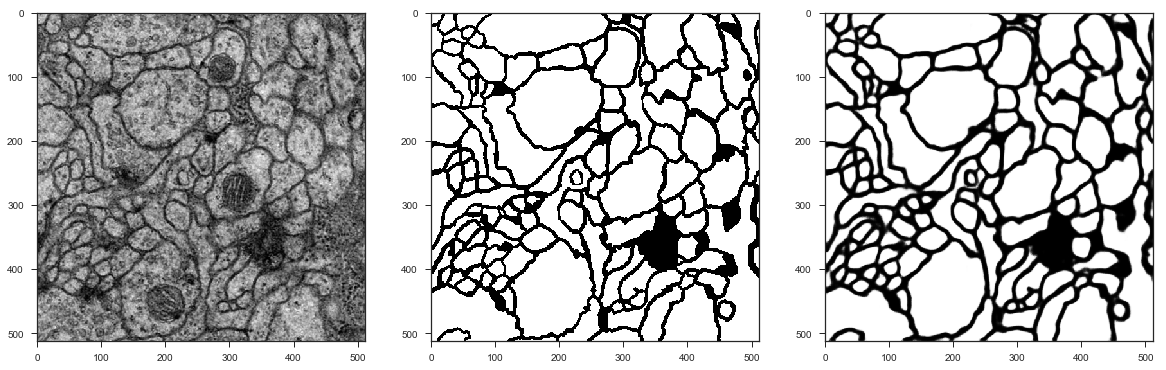

In [13]:
y_pred = model_unet_side_fuse.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

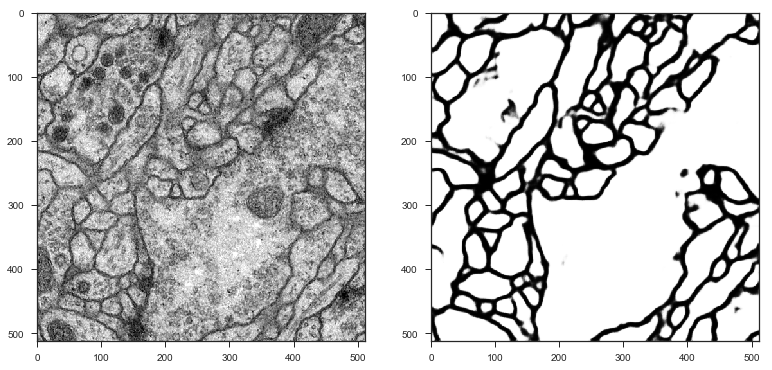

In [14]:
y_pred = model_unet_side_fuse.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [22]:
result = model_unet_side_fuse.predict(X_test)[-1]
result = result.astype(np.float32)
result.shape

(30, 512, 512, 1)

In [23]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Result_Tu_Lan_' + timestamp + '.tif', result, dtype=np.float32)

In [32]:
test_result = tiff.imread(RESULT_PATH + 'Result_Tu_Lan_20180509-162751.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

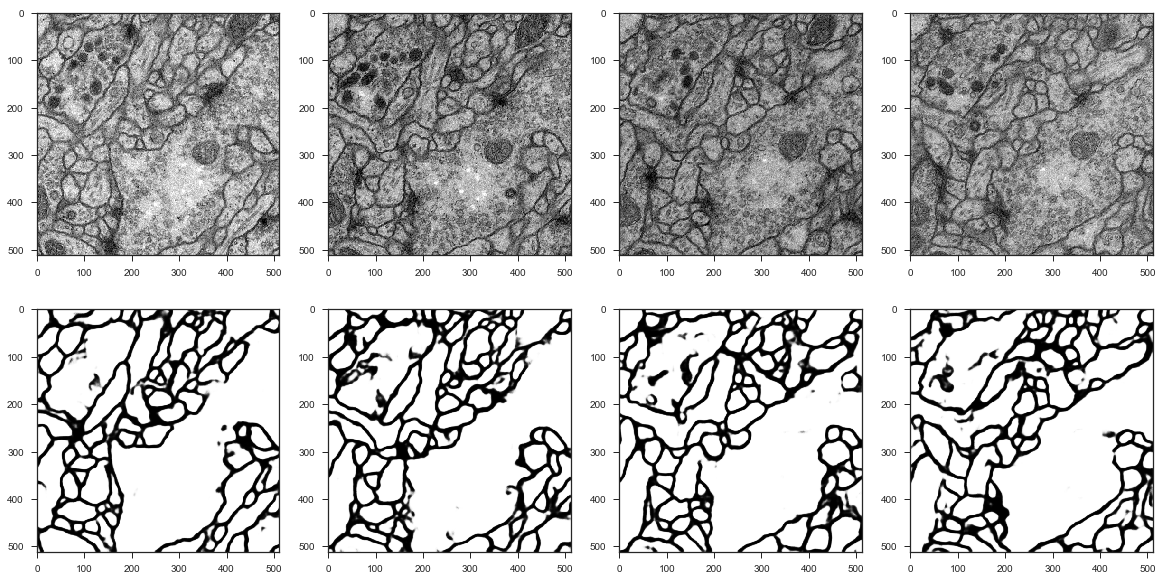

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()